In [1]:
## Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
from datetime import date
import math
import sys
import random
import swifter
import json
from geopandas.tools import geocode
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#conda install -c conda-forge anaconda geopandas swifter -y

# geopandas requires python>=3.8.10
# conda update --all
# conda install python=3.8.10

## Import data sets

**Due to size limitations from GitHub the csv files are not contained in the repository. You have to download the csv files manually into the same directory as the notebook**

In [3]:
#read in the data

chi_data = pd.read_csv("chicago_2017.csv")
chi_weather = pd.read_csv("weather_hourly_chicago.csv")

## General information about the raw data

### chicago_2017 data set

In [4]:
#chi_data.info()

In [5]:
#chi_data.describe()

In [6]:
#chi_data.head()

### weather_hourly_chicago data set

In [7]:
#chi_weather.info()

In [8]:
#chi_weather.describe()

In [9]:
#chi_weather.head(50)

## Add date time features to chi_data

In [10]:
chi_data['start_time'] = pd.to_datetime(chi_data['start_time'])
chi_data['end_time'] = pd.to_datetime(chi_data['end_time'])

In [11]:
chi_data.sort_values(['start_time'], inplace = True) #Sorts the values by date 

In [12]:
chi_data["Date"] = chi_data['start_time'].swifter.apply(lambda dt: dt.date())
chi_data["Month"] = chi_data['start_time'].swifter.apply(lambda dt: dt.month)
chi_data["Week"] = chi_data['start_time'].swifter.apply(lambda dt: dt.isocalendar()[1])
chi_data["Day"] = chi_data['start_time'].swifter.apply(lambda dt: dt.day)
chi_data["Hour"] = chi_data['start_time'].swifter.apply(lambda dt: dt.hour)
chi_data["Weekday"] = chi_data['start_time'].swifter.apply(lambda dt: dt.weekday())
chi_data['Duration'] = (chi_data['end_time']-chi_data['start_time'])
chi_data["Duration_sec"] = chi_data["Duration"].swifter.apply(lambda x: x.total_seconds())
chi_data["IsWeekday"] = chi_data["Weekday"].swifter.apply(lambda x: 1 if x < 5 else 0)
#chi_data.head()

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

## Add date weather features to chi_weather_2017

In [13]:
chi_weather['date_time'] = pd.to_datetime(chi_weather['date_time'])

In [14]:
first_date = datetime(year=2017, day=1, month=1)
last_date = datetime(year=2018, day=1, month=1)
chi_weather_2017 = chi_weather[(chi_weather['date_time']>=first_date)&(chi_weather["date_time"] <= last_date)]

In [15]:
chi_weather_2017 = chi_weather_2017.sort_values(by = "date_time") #sort the values by date time

In [16]:
chi_weather_2017["Date"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.date())
chi_weather_2017['Month']= chi_weather_2017["date_time"].swifter.apply(lambda dt: dt.month)
chi_weather_2017["Week"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.isocalendar()[1])
chi_weather_2017["Hour"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.hour)
chi_weather_2017["Weekday"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.weekday())
chi_weather_2017["mean_temp"] = (chi_weather_2017['max_temp']+chi_weather_2017['min_temp'])/2
#chi_weather_2017.head()

Pandas Apply:   0%|          | 0/8752 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8752 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8752 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8752 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8752 [00:00<?, ?it/s]

# `Data collection and preparation`

In [17]:
chi_data['Duration_sec'].describe()

count    3.829014e+06
mean     9.556289e+02
std      1.569593e+03
min     -3.120000e+03
25%      4.060000e+02
50%      6.850000e+02
75%      1.146000e+03
max      8.633800e+04
Name: Duration_sec, dtype: float64

In [18]:
chi_data['Duration_sec'].value_counts()

300.0      55446
360.0      54179
420.0      51548
240.0      50249
480.0      47799
           ...  
29935.0        1
12393.0        1
15424.0        1
30265.0        1
26519.0        1
Name: Duration_sec, Length: 16265, dtype: int64

In [19]:
chi_data.sort_values(by = 'Duration_sec')

start_time            end_time  start_station_id  \
3448503 2017-11-05 01:56:00 2017-11-05 01:04:00               295   
3448505 2017-11-05 01:54:00 2017-11-05 01:06:00               321   
3448506 2017-11-05 01:54:00 2017-11-05 01:06:00               321   
3448504 2017-11-05 01:54:00 2017-11-05 01:06:00               321   
3448500 2017-11-05 01:59:00 2017-11-05 01:13:00               327   
...                     ...                 ...               ...   
440556  2017-06-30 14:32:51 2017-07-01 14:27:16                84   
1278923 2017-05-01 15:00:41 2017-05-02 14:55:37               328   
877116  2017-06-04 13:07:01 2017-06-05 13:04:05               438   
21192   2017-03-27 20:09:57 2017-03-28 20:07:30                31   
29979   2017-03-26 08:07:43 2017-03-27 08:06:41               176   

         end_station_id            start_station_name  \
3448503             231          Broadway & Argyle St   
3448505             197           Wabash Ave & 9th St   
3448506             197           Wabash Ave & 9th St   
3448504             197           Wabash Ave & 9th St   
3448500             300   Sheffield Ave & Webster Ave   
...                 ...                           ...   
440556              508     Milwaukee Ave & Grand Ave   
1278923             420           Ellis Ave & 58th St   
877116              438  Central Park Ave & Ogden Ave   
21192                46     Franklin St & Chicago Ave   
29979               331             Clark St & Elm St   

                      end_station_name  bike_id   user_type        Date  \
3448503     Sheridan Rd & Montrose Ave     6085  Subscriber  2017-11-05   
3448505      Michigan Ave & Madison St     5707    Customer  2017-11-05   
3448506      Michigan Ave & Madison St     2083    Customer  2017-11-05   
3448504      Michigan Ave & Madison St     4905    Customer  2017-11-05   
3448500           Broadway & Barry Ave     6061  Subscriber  2017-11-05   
...                                ...      ...         ...         ...   
440556    Central Park Ave & North Ave     4914    Customer  2017-06-30   
1278923            Ellis Ave & 55th St     1146  Subscriber  2017-05-01   
877116    Central Park Ave & Ogden Ave      735    Customer  2017-06-04   
21192             Wells St & Walton St     4563    Customer  2017-03-27   
29979    Halsted St & Blackhawk St (*)     1138    Customer  2017-03-26   

         Month  Week  Day  Hour  Weekday          Duration  Duration_sec  \
3448503     11    44    5     1        6 -1 days +23:08:00       -3120.0   
3448505     11    44    5     1        6 -1 days +23:12:00       -2880.0   
3448506     11    44    5     1        6 -1 days +23:12:00       -2880.0   
3448504     11    44    5     1        6 -1 days +23:12:00       -2880.0   
3448500     11    44    5     1        6 -1 days +23:14:00       -2760.0   
...        ...   ...  ...   ...      ...               ...           ...   
440556       6    26   30    14        4   0 days 23:54:25       86065.0   
1278923      5    18    1    15        0   0 days 23:54:56       86096.0   
877116       6    22    4    13        6   0 days 23:57:04       86224.0   
21192        3    13   27    20        0   0 days 23:57:33       86253.0   
29979        3    12   26     8        6   0 days 23:58:58       86338.0   

         IsWeekday  
3448503          0  
3448505          0  
3448506          0  
3448504          0  
3448500          0  
...            ...  
440556           1  
1278923          1  
877116           0  
21192            1  
29979            0  

[3829014 rows x 17 columns]

In [20]:
chi_data_60sec_trips = chi_data[chi_data.Duration_sec < 60]
chi_data_60sec_trips.count()

#checking quantity of very short trips

start_time            11
end_time              11
start_station_id      11
end_station_id        11
start_station_name    11
end_station_name      11
bike_id               11
user_type             11
Date                  11
Month                 11
Week                  11
Day                   11
Hour                  11
Weekday               11
Duration              11
Duration_sec          11
IsWeekday             11
dtype: int64

In [21]:
chi_data_idcheck = chi_data[['start_station_id', 'start_station_name']]

In [22]:
grouped_chi_data = chi_data_idcheck.groupby(['start_station_id'])
grouped_chi_data = grouped_chi_data.agg({"start_station_name": "nunique"})

grouped_chi_data = grouped_chi_data. reset_index()

print(grouped_chi_data)

     start_station_id  start_station_name
0                   2                   1
1                   3                   1
2                   4                   1
3                   5                   1
4                   6                   1
..                ...                 ...
580               622                   1
581               623                   1
582               624                   1
583               625                   1
584               626                   1

[585 rows x 2 columns]


In [23]:
bad_ids = grouped_chi_data[grouped_chi_data['start_station_name']>1]
bad_ids.head(8)

#listing IDs that are associated with multiple names

start_station_id  start_station_name
13                 17                   2
49                 53                   2
67                 75                   2
298               321                   2
401               437                   2
443               480                   2
503               544                   2
533               574                   2

In [24]:
#chi_data.to_csv('cleanedtrips.csv')

# `Descriptive analytics`

## Overview Data

In [25]:
stations = len(grouped_chi_data['start_station_id'])
print("The overall number of stations is {}".format(stations))

bikes = len(chi_data['bike_id'].unique())
print("The overall number of bikes is {}".format(bikes))

trips = chi_data['start_time'].count()
print("The overall number of trips is {}".format(trips))


The overall number of stations is 585
The overall number of bikes is 6243
The overall number of trips is 3829014


## Temporal demand patterns

### Bike rentals

#### Bike rentals per month

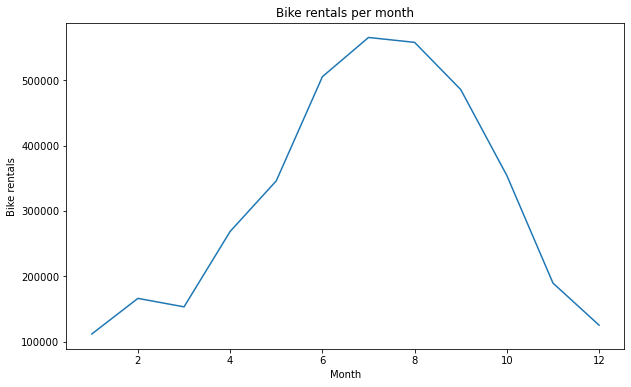

In [26]:
rentals_month = chi_data.groupby(['Month'])['bike_id'].count()
rentals_month = pd.DataFrame(rentals_month)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_month)
ax.set_title('Bike rentals per month')
ax.set_xlabel('Month')
ax.set_ylabel("Bike rentals")
plt.show()

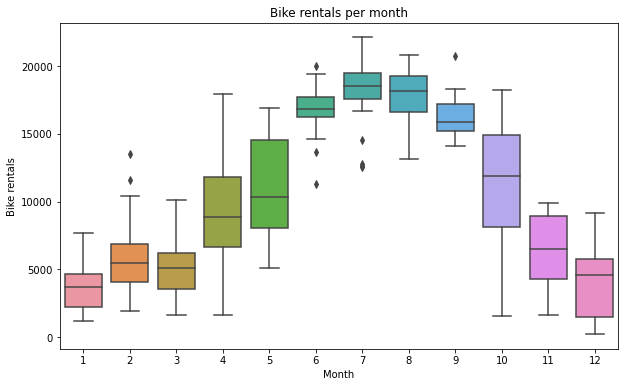

In [27]:
rentals_month_bp = chi_data.groupby(['Date','Month'])['bike_id'].count()
rentals_month_bp = pd.DataFrame(rentals_month_bp)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = rentals_month_bp.index.get_level_values('Month'), y =rentals_month_bp['bike_id'], ax = ax)
ax.set_title('Bike rentals per month')
ax.set_ylabel("Bike rentals")
plt.show()

#### Bike rentals per week

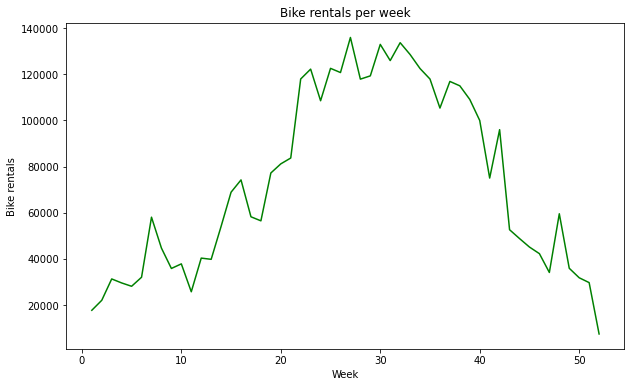

In [28]:
rentals_week = chi_data.groupby("Week")['bike_id'].count()
rentals_week = pd.DataFrame(rentals_week)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_week, c = "green")

ax.set_title('Bike rentals per week')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Week")
plt.show()

#### Bike rentals per weekday

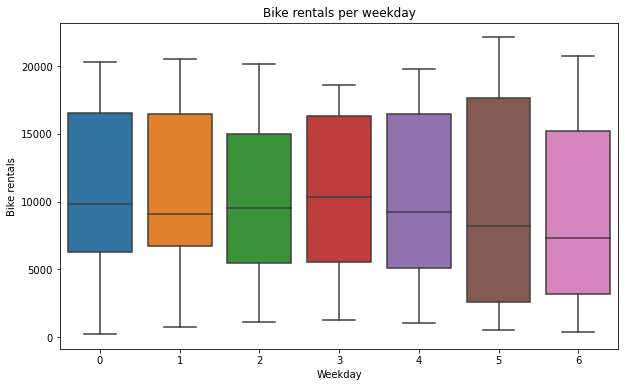

In [29]:
rentals_weekday = chi_data.groupby(['Weekday','Date'])['bike_id'].count()
rentals_weekday = pd.DataFrame(rentals_weekday)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = rentals_weekday.index.get_level_values('Weekday'), y =rentals_weekday['bike_id'], ax = ax)
ax.set_title('Bike rentals per weekday')
ax.set_ylabel("Bike rentals")

plt.show()

#### Bike rentals over year per day 

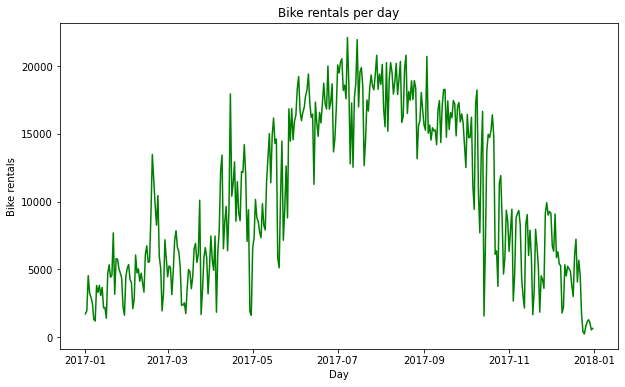

In [30]:
rentals_day = chi_data.groupby("Date")['bike_id'].count()
rentals_day = pd.DataFrame(rentals_day)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_day, c = "green")

ax.set_title('Bike rentals per day')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Day")
plt.show()

#### Bike rentals per hour

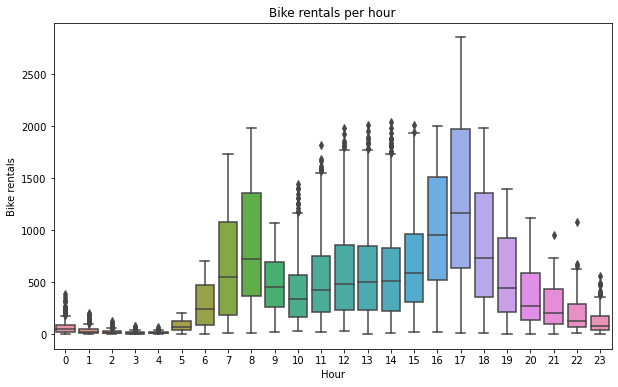

In [31]:
rentals_hour = chi_data.groupby(["Date","Hour"])['bike_id'].count()
rentals_hour =pd.DataFrame(rentals_hour)

fig, ax = plt.subplots(figsize = (10,6))


sns.boxplot(x = rentals_hour.index.get_level_values("Hour"), y =rentals_hour['bike_id'], ax = ax)
ax.set_title('Bike rentals per hour')
ax.set_ylabel("Bike rentals")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

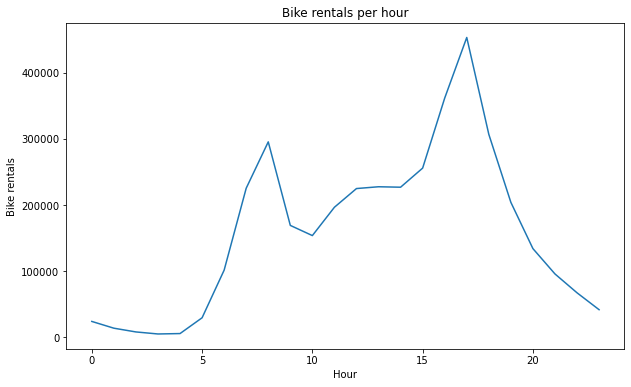

In [32]:
rentals_hour = chi_data.groupby(['Hour'])['bike_id'].count()
rentals_hour = pd.DataFrame(rentals_hour)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_hour)
ax.set_title('Bike rentals per hour')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Hour")
plt.show

### Duration/Travel time

#### Duration per week

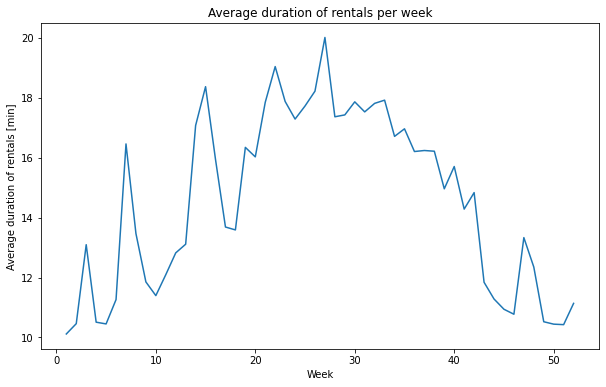

In [33]:
duration_week = chi_data.groupby("Week")["Duration_sec"].mean()/60
duration_week = pd.DataFrame(duration_week)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(duration_week)

ax.set_title('Average duration of rentals per week')
ax.set_ylabel('Average duration of rentals [min]')
ax.set_xlabel('Week')
plt.show()

#### Duration per weekday

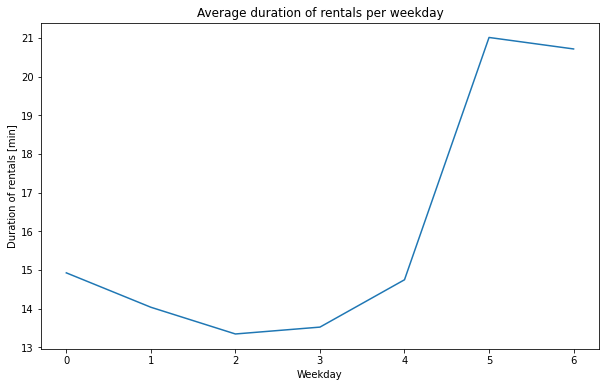

In [34]:
duration_weekday = chi_data.groupby("Weekday")["Duration_sec"].mean()/60
duration_weekday = pd.DataFrame(duration_weekday)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(duration_weekday)

ax.set_title('Average duration of rentals per weekday')
ax.set_ylabel('Duration of rentals [min]')
ax.set_xlabel('Weekday')
plt.show()

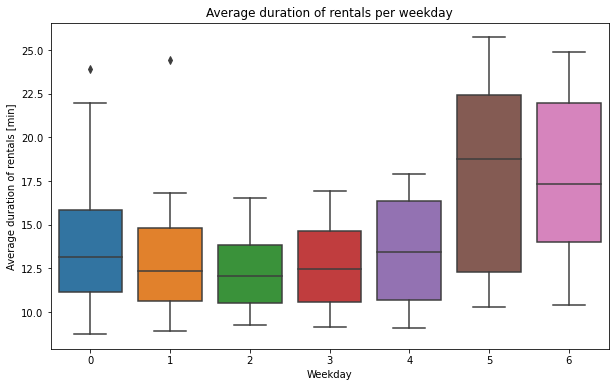

In [35]:
duration_weekday_bp = chi_data.groupby(["Date","Weekday"])['Duration_sec'].mean()/60
duration_weekday_bp =pd.DataFrame(duration_weekday_bp)

fig, ax = plt.subplots(figsize = (10,6))


sns.boxplot(x = duration_weekday_bp.index.get_level_values("Weekday"), y =duration_weekday_bp['Duration_sec'], ax = ax)
ax.set_title('Average duration of rentals per weekday')
ax.set_ylabel('Average duration of rentals [min]')
plt.show()

#### Duration per hour

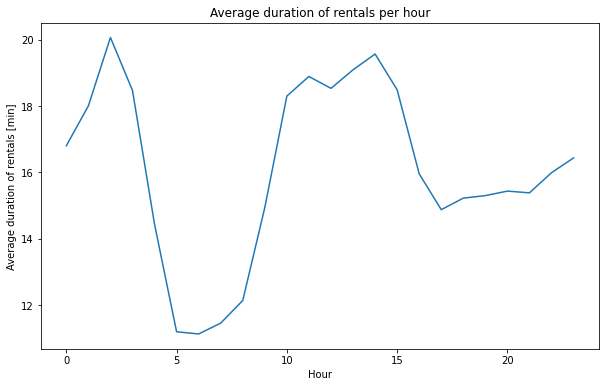

In [36]:
duration_hour = chi_data.groupby("Hour")["Duration_sec"].mean()/60
duration_hour = pd.DataFrame(duration_hour)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(duration_hour, )

ax.set_title('Average duration of rentals per hour')
ax.set_ylabel('Average duration of rentals [min]')
ax.set_xlabel('Hour')
plt.show()

### Weather

#### Temperature monthly

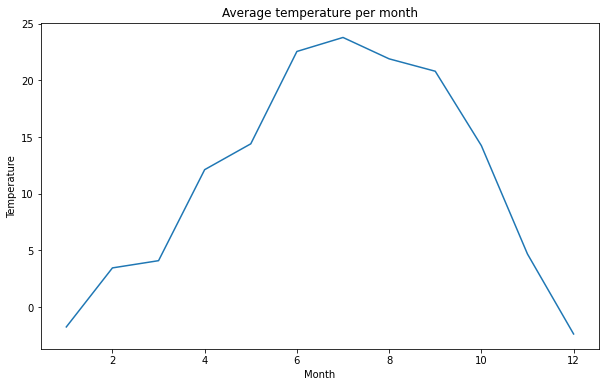

In [37]:
temp_month_mean = chi_weather_2017.groupby("Month")["mean_temp"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_month_mean)
ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
ax.set_title("Average temperature per month")

plt.show()

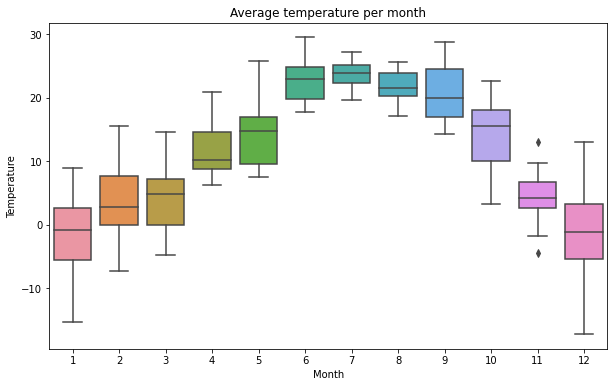

In [38]:
temp_month_mean_bp = chi_weather_2017.groupby(['Date','Month'])['mean_temp'].mean()
temp_month_mean_bp = pd.DataFrame(temp_month_mean_bp)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = temp_month_mean_bp.index.get_level_values('Month'), y =temp_month_mean_bp['mean_temp'], ax = ax)

ax.set_title('Average temperature per month')
ax.set_ylabel("Temperature")
ax.set_xlabel("Month")
plt.show()

#### Temperature weekly

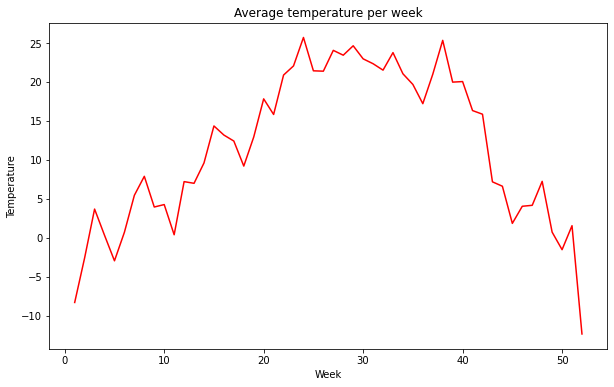

In [39]:
temp_week_mean = chi_weather_2017.groupby("Week")["mean_temp"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_week_mean, c = "red")
ax.set_ylabel("Temperature")
ax.set_xlabel('Week')
ax.set_title('Average temperature per week')
plt.show()

#### Temperature daily

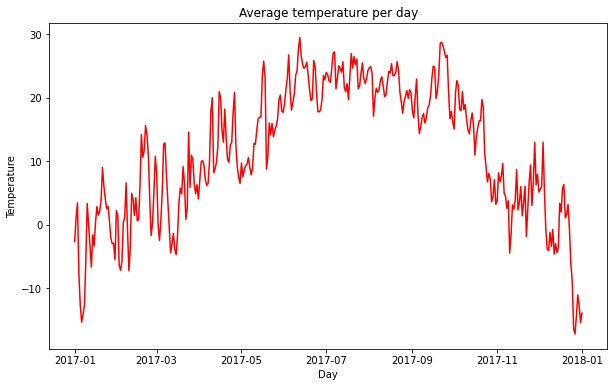

In [40]:
temp_day_mean = chi_weather_2017.groupby("Date")["mean_temp"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_day_mean, c = "red")
ax.set_title('Average temperature per day')
ax.set_ylabel("Temperature")
ax.set_xlabel('Day')

plt.show()

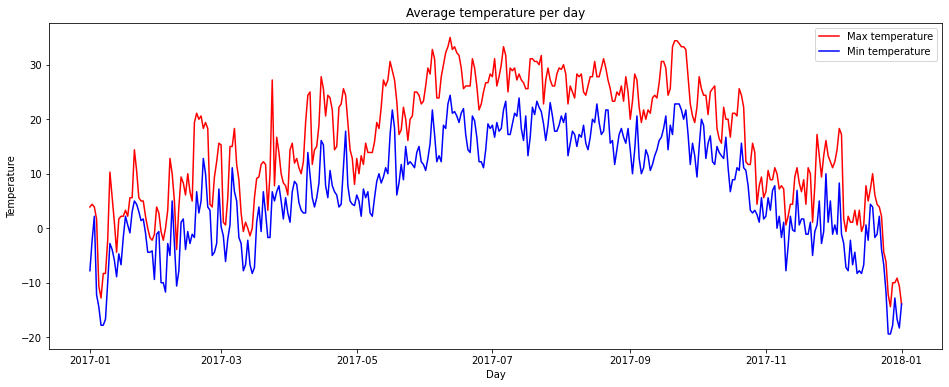

In [41]:
temp_day_min = chi_weather_2017.groupby("Date")["mean_temp"].min()
temp_day_max = chi_weather_2017.groupby("Date")["mean_temp"].max()

fig, ax = plt.subplots(figsize = (16,6))

ax.plot(temp_day_max, c = "red", label = "Max temperature")
ax.plot(temp_day_min, c = "blue", label = "Min temperature")
plt.legend()
ax.set_title('Average temperature per day')
ax.set_ylabel("Temperature")
ax.set_xlabel('Day')

plt.show()

#### Precip monthly

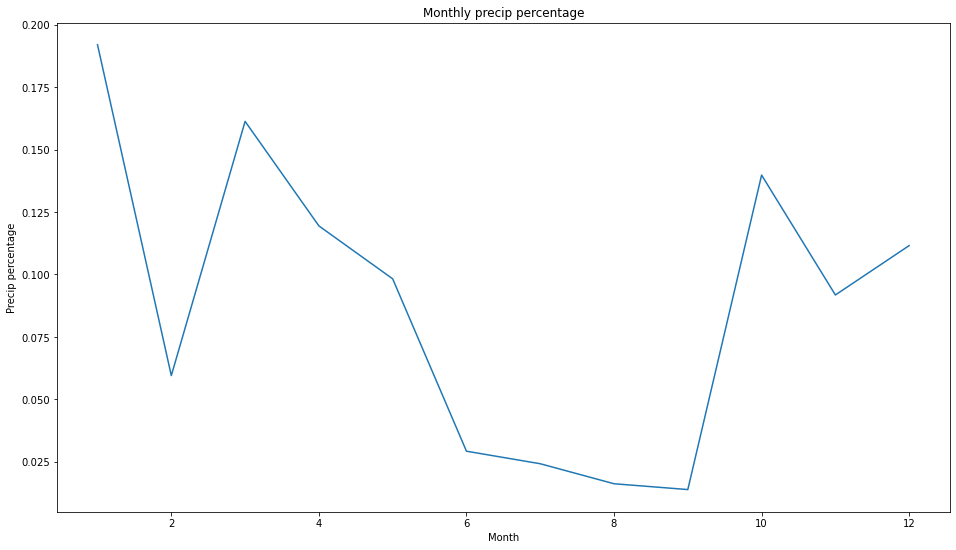

In [42]:
precip_month_mean = chi_weather_2017.groupby("Month")["precip"].mean()

fig, ax = plt.subplots(figsize = (16,9))

ax.plot(precip_month_mean)
ax.set_xlabel('Month')
ax.set_ylabel('Precip percentage')
ax.set_title("Monthly precip percentage")

plt.show()

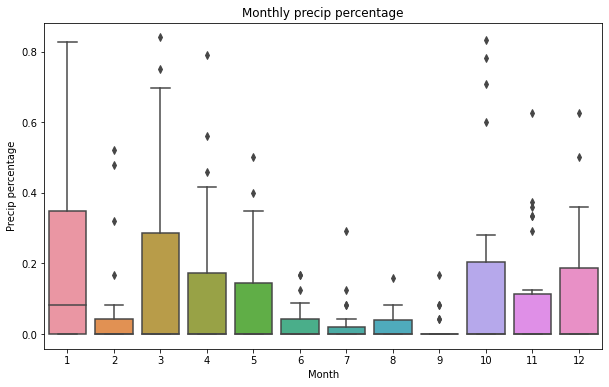

In [43]:
precip_month_mean_bp = chi_weather_2017.groupby(['Date','Month'])['precip'].mean()
precip_month_mean_bp = pd.DataFrame(precip_month_mean_bp)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = precip_month_mean_bp.index.get_level_values('Month'), y =precip_month_mean_bp['precip'], ax = ax)

ax.set_xlabel('Month')
ax.set_ylabel('Precip percentage')
ax.set_title("Monthly precip percentage")
plt.show()

#### Precip weekly

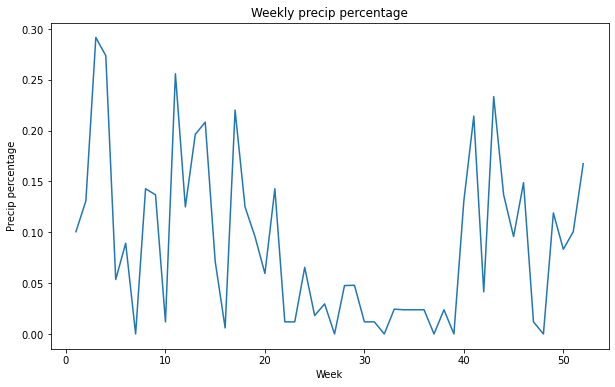

In [44]:
precip_week_mean = chi_weather_2017.groupby("Week")["precip"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(precip_week_mean)
ax.set_title('Weekly precip percentage')
ax.set_ylabel("Precip percentage")
ax.set_xlabel('Week')
plt.show()

#### Precip daily

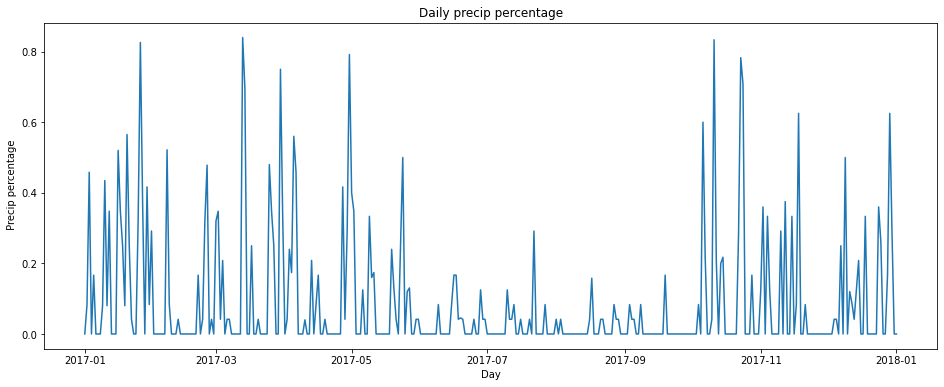

In [45]:
precip_day_mean = chi_weather_2017.groupby("Date")["precip"].mean()

fig, ax = plt.subplots(figsize = (16,6))

ax.plot(precip_day_mean)
ax.set_title('Daily precip percentage')
ax.set_ylabel(" Precip percentage")
ax.set_xlabel('Day')
plt.show()

### Correlation between rentals and weather 

#### Rescaling

In [46]:
rentals_day_resc = (rentals_day-rentals_day.min())/(rentals_day.max()-rentals_day.min())
rentals_week_resc = ((rentals_week-rentals_week.min())/(rentals_week.max()-rentals_week.min()))
rentals_month_resc = ((rentals_month-rentals_month.min())/(rentals_month.max()-rentals_month.min()))

precip_day_resc = (precip_day_mean-precip_day_mean.min())/(precip_day_mean.max()-precip_day_mean.min())
precip_week_resc = (precip_week_mean-precip_week_mean.min())/(precip_week_mean.max()-precip_week_mean.min())
precip_month_resc = (precip_month_mean-precip_month_mean.min())/(precip_month_mean.max()-precip_month_mean.min())

temp_day_resc = (temp_day_mean-temp_day_mean.min())/(temp_day_mean.max()-temp_day_mean.min())
temp_week_resc = (temp_week_mean-temp_week_mean.min())/(temp_week_mean.max()-temp_week_mean.min())
temp_month_resc = ((temp_month_mean-temp_month_mean.min())/(temp_month_mean.max()-temp_month_mean.min()))

#### Rentals and temperatur

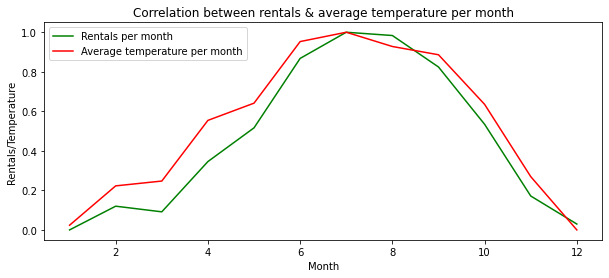

In [47]:
fig, ax = plt.subplots(figsize = (10,4))

ax.plot(rentals_month_resc, c = 'green', label='Rentals per month')
ax.plot(temp_month_resc, c = 'red', label='Average temperature per month')

ax.set_title('Correlation between rentals & average temperature per month')
ax.set_xlabel('Month')
ax.set_ylabel('Rentals/Temperature')
ax.legend()

plt.show()

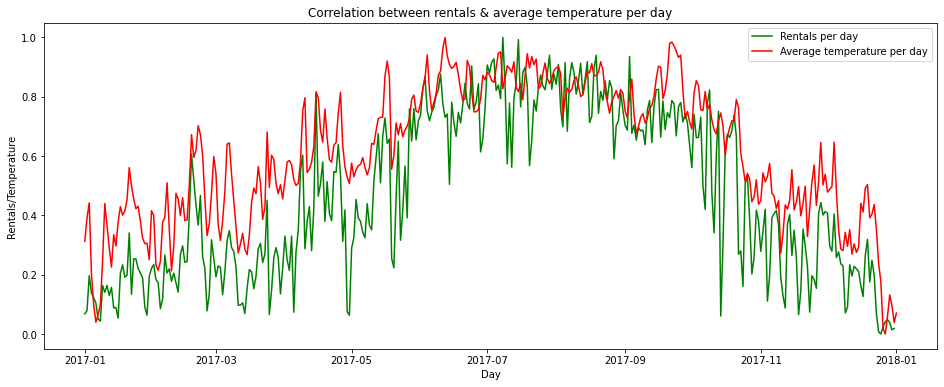

In [48]:
fig, ax = plt.subplots(figsize = (16,6))

ax.plot(rentals_day_resc, c = 'green', label='Rentals per day')
ax.plot(temp_day_resc, c = 'red', label='Average temperature per day')

ax.set_title('Correlation between rentals & average temperature per day')
ax.set_xlabel('Day')
ax.set_ylabel('Rentals/Temperature')
ax.legend()

plt.show()

In [49]:
#Put weather & rental data into the same data frame
temp_rentals_day = chi_weather_2017.groupby(["Date"])["mean_temp"].mean()
temp_rentals_day = pd.DataFrame(temp_rentals_day)
temp_rentals_day["Rentals"] = chi_data.groupby(['Date'])['bike_id'].count()
temp_rentals_day["IsWeekday"] = chi_data.groupby(['Date'])['IsWeekday'].max()

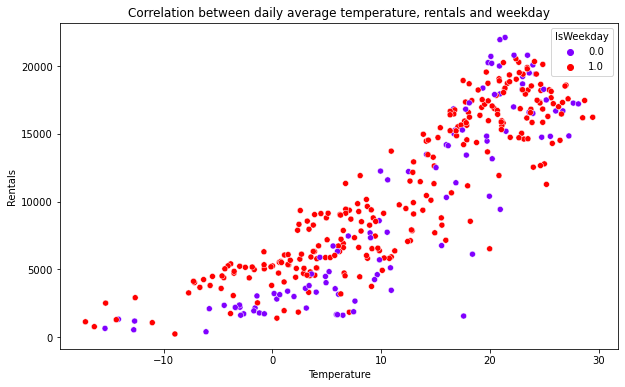

In [50]:
fig, ax = plt.subplots(figsize = (10,6))

sns.scatterplot(x = temp_rentals_day["mean_temp"], y= temp_rentals_day["Rentals"], hue = temp_rentals_day["IsWeekday"], palette = "rainbow" )
ax.set_title("Correlation between daily average temperature, rentals and weekday")
ax.set_xlabel("Temperature")
plt.show()

#### Rentals and precip

In [51]:
#Put precip & rental data into the same data frame
precip_rentals_day = chi_weather_2017.groupby(["Date"])["precip"].mean()
precip_rentals_day = pd.DataFrame(precip_rentals_day)
precip_rentals_day["Rentals"] = chi_data.groupby(['Date'])['bike_id'].count()
precip_rentals_day["IsWeekday"] = chi_data.groupby(['Date'])['IsWeekday'].max()

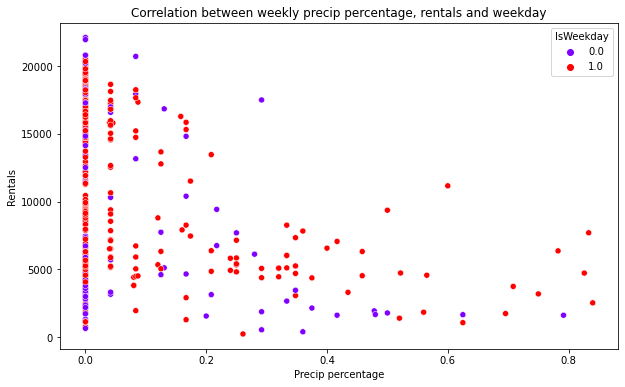

In [52]:

fig, ax = plt.subplots(figsize = (10,6))

sns.scatterplot(x = precip_rentals_day["precip"], y= precip_rentals_day["Rentals"], hue = precip_rentals_day["IsWeekday"],palette="rainbow" )
ax.set_title("Correlation between weekly precip percentage, rentals and weekday")
ax.set_xlabel("Precip percentage")
plt.show()

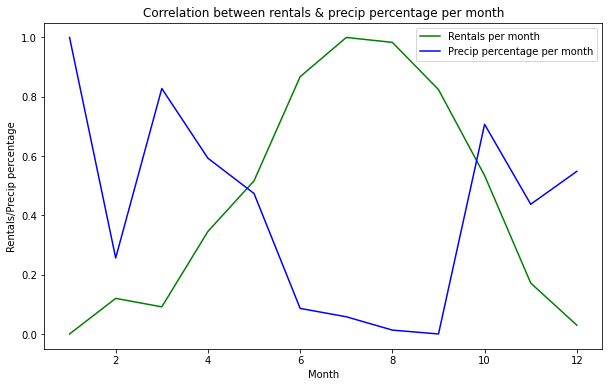

In [53]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_month_resc, c = 'green', label='Rentals per month')
ax.plot(precip_month_resc, c = 'blue', label='Precip percentage per month')

ax.set_title('Correlation between rentals & precip percentage per month')
ax.set_xlabel('Month')
ax.set_ylabel('Rentals/Precip percentage')
ax.legend()

plt.show()

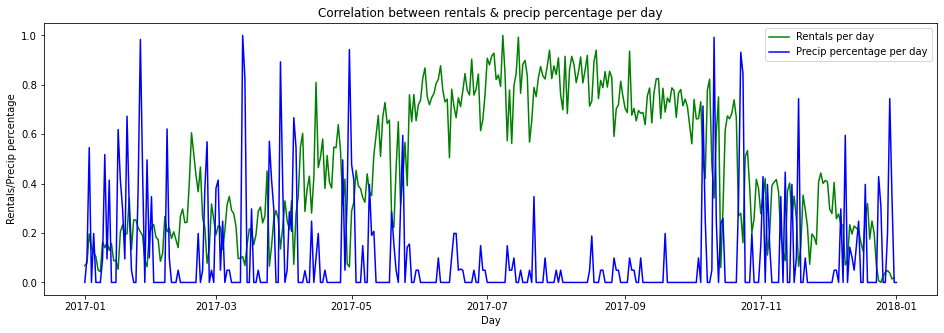

In [54]:
fig, ax = plt.subplots(figsize = (16,5))

ax.plot(rentals_day_resc, c = 'green', label='Rentals per day')
ax.plot(precip_day_resc, c = 'blue', label='Precip percentage per day')

ax.set_title('Correlation between rentals & precip percentage per day')
ax.set_xlabel('Day')
ax.set_ylabel('Rentals/Precip percentage')
ax.legend()

plt.show()

### Correlation between rentals duration and weather 

In [55]:
duration_week_resc = (duration_week-duration_week.min())/(duration_week.max()-duration_week.min())

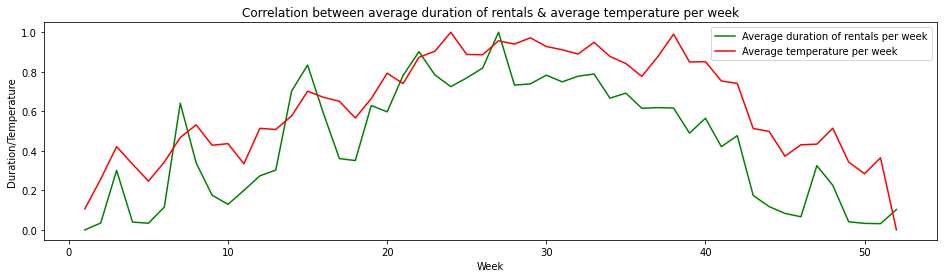

In [56]:
fig, ax = plt.subplots(figsize = (16,4))

ax.plot(duration_week_resc, c = 'green', label='Average duration of rentals per week')
ax.plot(temp_week_resc, c = 'red', label='Average temperature per week')

ax.set_title('Correlation between average duration of rentals & average temperature per week')
ax.set_xlabel('Week')
ax.set_ylabel('Duration/Temperature')
ax.legend()

plt.show()

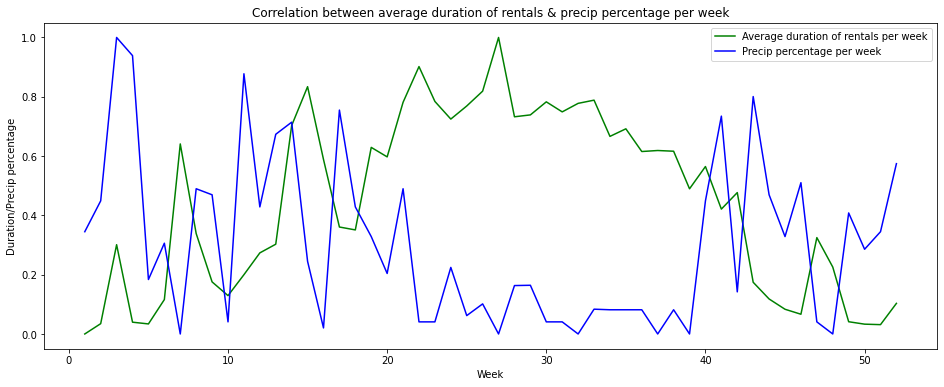

In [57]:
fig, ax = plt.subplots(figsize = (16,6))

ax.plot(duration_week_resc, c = 'green', label='Average duration of rentals per week')
ax.plot(precip_week_resc, c = 'blue', label='Precip percentage per week')

ax.set_title('Correlation between average duration of rentals & precip percentage per week')
ax.set_xlabel('Week')
ax.set_ylabel('Duration/Precip percentage')
ax.legend()

plt.show()

## Geographical demand patterns

In [58]:
chi_stations = pd.read_csv("chicago_2017.csv")

#### Creating location dictionary for location
!!! This must be done only once, for further usage simply read in the created json file (see next section) !!!

In [59]:
# example api request
geocode("Universität Köln", provider="nominatim", user_agent='my_request')

geometry                                            address
0  POINT (6.92817 50.92804)  Universität zu Köln, Heimbacher Straße, Kriel,...

In [60]:
def getLocation(x):
    try:
        location = geocode(x + ", Chicago", provider="nominatim", user_agent='my_request')
        point = location.geometry.iloc[0]
        return (f"{round(point.y, 5)} {round(point.x, 5)}")
    except:
        return 'NaN'

In [61]:
## commenting out to prevent running everything all the time

In [62]:
# UniqueAdresses = chi_stations['start_station_name'].unique()
# locDict = dict(zip(UniqueAdresses, pd.Series(UniqueAdresses).swifter.apply(lambda x: getLocation(x))))

In [63]:
## check if the list of stations are identical
# UniqueAdresses2 = chi_stations['end_station_name'].unique()
# locDict2 = dict(zip(UniqueAdresses2, pd.Series(UniqueAdresses2).swifter.apply(lambda x: getLocation(x))))


# set(locDict.keys()) == set(locDict2.keys())

In [64]:
## storing the location dictionary into a json file 
## for better look you should beaufify the json with some online tools
# with open('locDict.json', 'w') as file:
#      file.write(json.dumps(locDict))

#### Accessing and formatting the location data from our created json dictionary

In [65]:
# retrieve the location dictionary from the json file
with open('locDict.json', 'r') as file:
     newLocDict = json.loads(file.read())

In [66]:
# formatting the retrieved data into location tuples
def convertToTuple(x):
    if not x == "NaN":
        return tuple(map(float, x.split(" ")))
    else:
        return float('NaN')

In [67]:
chi_stations['start_station_coordinates'] = chi_stations['start_station_name'].map(newLocDict)
chi_stations['start_station_coordinates'] = chi_stations['start_station_coordinates'].swifter.apply(lambda x: convertToTuple(x))

Pandas Apply:   0%|          | 0/3829014 [00:00<?, ?it/s]

In [68]:
missingLocations = chi_stations[chi_stations["start_station_coordinates"].isnull()==True]["start_station_name"].count()
print(f"There are still {missingLocations} 'NaN' values in our coordinates where geocode didn't find a location according to the address")

There are still 196865 'NaN' values in our coordinates where geocode didn't find a location according to the address


In [69]:
chi_stations = chi_stations[chi_stations["start_station_coordinates"].isnull()==False]

### Mapping our stations

mapping out the stations in chicago

In [70]:
positions = list(chi_stations["start_station_coordinates"].unique())

chi_stations_map = folium.Map(location=(41.8856, -87.6415),  
                                tiles='Stamen Toner',
                                zoom_start=12, 
                                control_scale=True, 
                                max_zoom=20)

for position in positions:
    folium.CircleMarker(radius=5, location=position, popup='The Waterfront', 
                                 color='crimson', fill_color='crimson').add_to(chi_stations_map)
    
chi_stations_map

usage of every station visualized in a heatmap

In [71]:
chi_heat_map = folium.Map(location=(41.8856, -87.6415),
                            tiles='OpenStreetMap',
                            zoom_start=12,
                            control_scale=True,
                            max_zoom=20)

In [72]:
# get values for the new dataframe
chi_stations_usage = chi_stations.groupby(["start_station_name"])["bike_id"].count()
chi_stations_usage = pd.DataFrame({'start_station_name':chi_stations_usage.index, 'bike_id_count':chi_stations_usage.values})

# retrieve location data and convert it
chi_stations_usage["start_station_coordinates"] = chi_stations_usage["start_station_name"].map(newLocDict)
chi_stations_usage['start_station_coordinates'] = chi_stations_usage['start_station_coordinates'].swifter.apply(lambda x: convertToTuple(x))

# zip location and bike_id_count for heatmap
chi_stations_usage['heatmap_data'] = [a + (b,) for a, b in zip(chi_stations_usage['start_station_coordinates'], chi_stations_usage['bike_id_count'])]

Pandas Apply:   0%|          | 0/537 [00:00<?, ?it/s]

In [73]:
# replacing first entry with CircleMarker in order to keep heatmap weighting in reasonable scale
chi_stations_usage.sort_values("bike_id_count", ascending=False).head()

start_station_name  bike_id_count start_station_coordinates  \
474       Streeter Dr & Grand Ave          97571     (41.89224, -87.61195)   
284     Lake Shore Dr & Monroe St          53400     (41.88094, -87.61678)   
77            Canal St & Adams St          50911     (41.87923, -87.64002)   
135  Clinton St & Washington Blvd          49832     (41.88346, -87.64116)   
476           Theater on the Lake          47908     (41.92718, -87.63074)   

                     heatmap_data  
474  (41.89224, -87.61195, 97571)  
284  (41.88094, -87.61678, 53400)  
77   (41.87923, -87.64002, 50911)  
135  (41.88346, -87.64116, 49832)  
476  (41.92718, -87.63074, 47908)

In [74]:
# adding deleted point
folium.CircleMarker(radius=15, 
                    location=chi_stations_usage.start_station_coordinates[chi_stations_usage['bike_id_count'].idxmax()],
                    popup='Outliner',
                    color='crimson', 
                    fill_color='crimson').add_to(chi_heat_map)

chi_stations_usage = chi_stations_usage.drop(chi_stations_usage['bike_id_count'].idxmax())

In [75]:
# adding heatmap values
chi_heat_map.add_child(plugins.HeatMap(chi_stations_usage["heatmap_data"], radius=25, blur = 15, min_opacity = .3))
chi_heat_map

# `KPIs`

### Total bike usage

In [76]:
chi_data["date_hour"] = chi_data["start_time"].dt.floor("H")

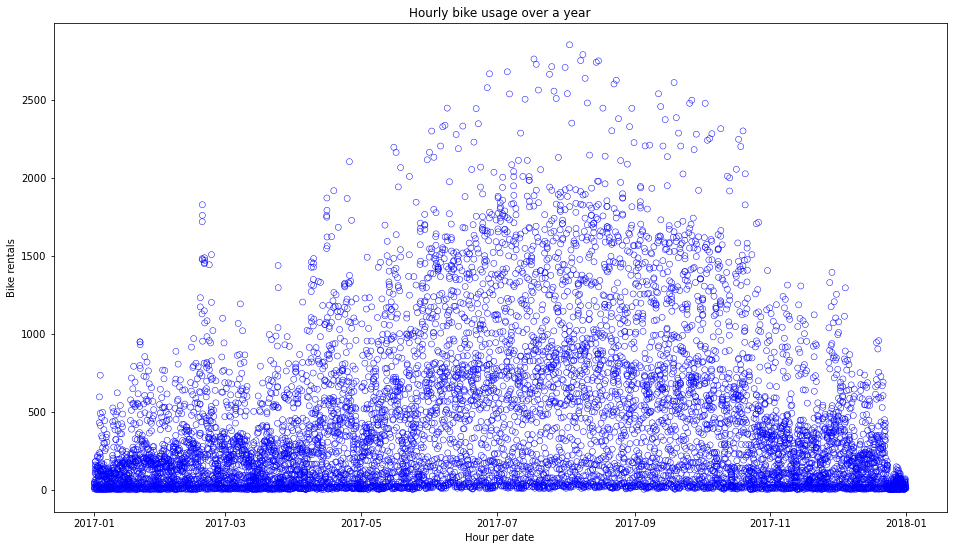

In [77]:
rentals_date_hour = chi_data.groupby("date_hour")['bike_id'].count()
rentals_date_hour = pd.DataFrame(rentals_date_hour)

fig, ax = plt.subplots(figsize = (16,9))


sns.scatterplot(x = rentals_date_hour.index.get_level_values("date_hour"), y =rentals_date_hour['bike_id'], ax = ax, color = "none", ec = "blue")
ax.set_title('Hourly bike usage over a year')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Hour per date")
plt.show()
rentals_date_hour.columns = ['Bike Usage']

In [78]:
rentals_date_hour["date_hour"] =rentals_date_hour.index

In [79]:
rentals_date_hour["Hour"] = rentals_date_hour['date_hour'].swifter.apply(lambda dt: dt.hour)
rentals_date_hour["Month"] = rentals_date_hour['date_hour'].swifter.apply(lambda dt: dt.month)
rentals_date_hour["Day"] = rentals_date_hour['date_hour'].swifter.apply(lambda dt: dt.day)
rentals_date_hour.pop("date_hour")

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

date_hour
2017-01-01 00:00:00   2017-01-01 00:00:00
2017-01-01 01:00:00   2017-01-01 01:00:00
2017-01-01 02:00:00   2017-01-01 02:00:00
2017-01-01 03:00:00   2017-01-01 03:00:00
2017-01-01 04:00:00   2017-01-01 04:00:00
                              ...        
2017-12-31 19:00:00   2017-12-31 19:00:00
2017-12-31 20:00:00   2017-12-31 20:00:00
2017-12-31 21:00:00   2017-12-31 21:00:00
2017-12-31 22:00:00   2017-12-31 22:00:00
2017-12-31 23:00:00   2017-12-31 23:00:00
Name: date_hour, Length: 8743, dtype: datetime64[ns]

In [80]:
#Function that returns the total bike usage of specified day, month and hour.
def calculateNumberRentalsSpecificHour(day, month, hour):
    x = rentals_date_hour[(rentals_date_hour["Day"] == day) & (rentals_date_hour["Month"] == month) & (rentals_date_hour["Hour"] == hour)]
    y = x["Bike Usage"]
    y = pd.DataFrame(y)
    return y

In [81]:
#Output for 02.01.2017 hour 1
calculateNumberRentalsSpecificHour(2, 1, 1)

Bike Usage
date_hour                      
2017-01-02 01:00:00          10

### Fleet utilization

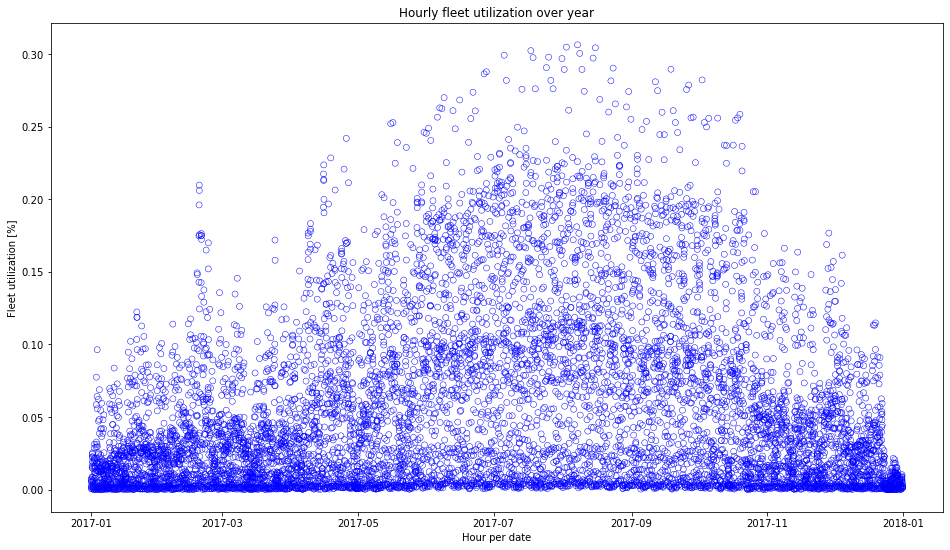

In [82]:
fleet_utilization = chi_data.groupby("date_hour")['bike_id'].nunique()/bikes
fleet_utilization =pd.DataFrame(fleet_utilization)

fig, ax = plt.subplots(figsize = (16,9))


sns.scatterplot(x = fleet_utilization.index.get_level_values("date_hour"), y =fleet_utilization['bike_id'], ax = ax, color = "none", ec = "blue")
ax.set_title('Hourly fleet utilization over year')
ax.set_ylabel("Fleet utilization [%]")
ax.set_xlabel("Hour per date")
plt.show()

In [83]:
fleet_utilization["date_hour"] = fleet_utilization.index
fleet_utilization["Year"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.year)
fleet_utilization["Hour"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.hour)
fleet_utilization["Month"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.month)
fleet_utilization["Day"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.day)
fleet_utilization.pop("date_hour")

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

date_hour
2017-01-01 00:00:00   2017-01-01 00:00:00
2017-01-01 01:00:00   2017-01-01 01:00:00
2017-01-01 02:00:00   2017-01-01 02:00:00
2017-01-01 03:00:00   2017-01-01 03:00:00
2017-01-01 04:00:00   2017-01-01 04:00:00
                              ...        
2017-12-31 19:00:00   2017-12-31 19:00:00
2017-12-31 20:00:00   2017-12-31 20:00:00
2017-12-31 21:00:00   2017-12-31 21:00:00
2017-12-31 22:00:00   2017-12-31 22:00:00
2017-12-31 23:00:00   2017-12-31 23:00:00
Name: date_hour, Length: 8743, dtype: datetime64[ns]

In [84]:
fu_daily = fleet_utilization.groupby(['Year','Month','Day'])['bike_id'].mean()
fu_daily = pd.DataFrame(fu_daily)
fu_daily["Month"] = fu_daily.index.get_level_values('Month')
fu_daily["Day"] = fu_daily.index.get_level_values('Day')
fu_daily["Year"] = 2017

fu_daily['Date'] = pd.to_datetime(fu_daily[['Year','Month','Day']])

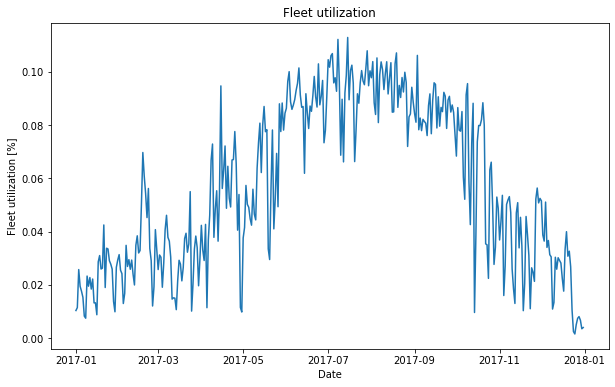

In [85]:
fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = fu_daily['Date'], y =fu_daily['bike_id'], ax = ax)
ax.set_title('Fleet utilization')
ax.set_ylabel('Fleet utilization [%]')
plt.show()

In [86]:
#Function that returns the relative utilization of the fleet for a specified day, month and hour.
def calculateFleetUtilization(day, month, hour):
    x = fleet_utilization[(fleet_utilization["Day"] == day) & (fleet_utilization["Month"] == month) & (fleet_utilization["Hour"] == hour)]
    y = x["bike_id"]
    y = pd.DataFrame(y)
    return y

In [87]:
#Output for 15.08.2017 hour 8
calculateFleetUtilization(15,8,8)

bike_id
date_hour                    
2017-08-15 08:00:00  0.229217

### Duration of rentals

In [88]:
duration = chi_data.groupby("date_hour")['Duration_sec'].mean()
duration =pd.DataFrame(duration)
duration["mean_minutes"]= duration["Duration_sec"]/60
duration["min_minutes"]=  chi_data.groupby("date_hour")['Duration_sec'].min()/60
duration["max_minutes"]=  chi_data.groupby("date_hour")['Duration_sec'].max()/60

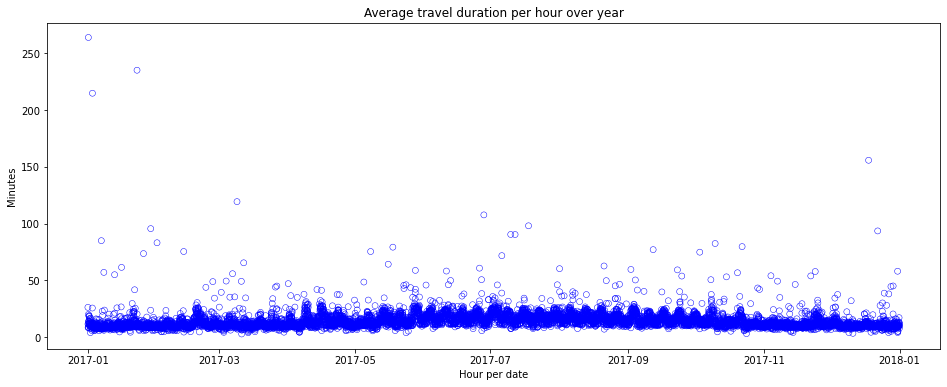

In [89]:
fig, ax = plt.subplots(figsize = (16,6))

sns.scatterplot(x = duration.index.get_level_values("date_hour"), y =duration['mean_minutes'], ax = ax, color = "none", ec = "blue")
ax.set_title('Average travel duration per hour over year')
ax.set_ylabel("Minutes")
ax.set_xlabel("Hour per date")
plt.show()

In [90]:
duration["date_hour"] =duration.index
duration["Hour"] = duration['date_hour'].swifter.apply(lambda dt: dt.hour)
duration["Month"] = duration['date_hour'].swifter.apply(lambda dt: dt.month)
duration["Day"] = duration['date_hour'].swifter.apply(lambda dt: dt.day)
duration.pop("date_hour")

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

date_hour
2017-01-01 00:00:00   2017-01-01 00:00:00
2017-01-01 01:00:00   2017-01-01 01:00:00
2017-01-01 02:00:00   2017-01-01 02:00:00
2017-01-01 03:00:00   2017-01-01 03:00:00
2017-01-01 04:00:00   2017-01-01 04:00:00
                              ...        
2017-12-31 19:00:00   2017-12-31 19:00:00
2017-12-31 20:00:00   2017-12-31 20:00:00
2017-12-31 21:00:00   2017-12-31 21:00:00
2017-12-31 22:00:00   2017-12-31 22:00:00
2017-12-31 23:00:00   2017-12-31 23:00:00
Name: date_hour, Length: 8743, dtype: datetime64[ns]

In [91]:
#Function that returns the relative utilization of the fleet for a specified day, month and hour.
def calculateDuration(day, month, hour):
    x = duration[(duration["Day"] == day) & (duration["Month"] == month) & (duration["Hour"] == hour)]
    y = x["mean_minutes"]
    y = pd.DataFrame(y)
    y["min_minutes"] = x["min_minutes"]
    y["max_minutes"] = x["max_minutes"]

    return y

In [92]:
calculateDuration(12,8,12)

mean_minutes  min_minutes  max_minutes
date_hour                                                  
2017-08-12 12:00:00     23.987616         1.05        299.8

### Distribution of rentals among customers and subscribers

for better overview we are grouping by week

In [93]:
chi_usage = chi_data.groupby(["Week"])["bike_id"].count()
chi_usage_subs = chi_data[chi_data["user_type"]=="Subscriber"].groupby(["Week"])["bike_id"].count()
chi_usage_custo = chi_data[chi_data["user_type"]=="Customer"].groupby(["Week"])["bike_id"].count()

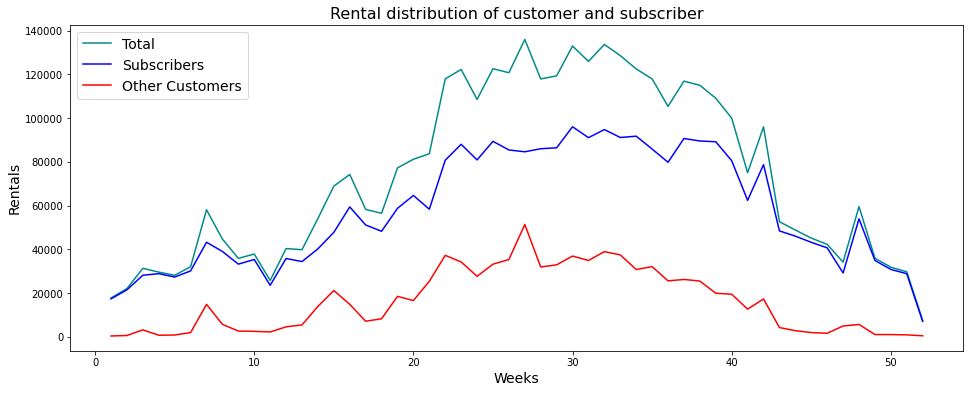

In [94]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(chi_usage, label="Total", color='darkcyan')
ax.plot(chi_usage_subs, label="Subscribers", color='b')
ax.plot(chi_usage_custo, label="Other Customers", color='r')

ax.set_title("Rental distribution of customer and subscriber", fontsize=16)
ax.set_ylabel("Rentals", fontsize=14)
ax.set_xlabel("Weeks", fontsize=14)
ax.legend(fontsize=14, loc="upper left")
plt.show()

### Bike station utilization

In [95]:
#Function that returns the relative utilization of the fleet for a specified day, month and hour.
def calculateStationUtilization(day, month, hour):
    x = chi_data[(chi_data["Day"] == day) & (chi_data["Month"] == month) & (chi_data["Hour"] == hour)]
    y = x.groupby(["start_station_name"])["bike_id"].count()
    y = pd.DataFrame({'start_station_name':y.index, 'bike_id_count':y.values})
    y["start_station_coordinates"] = y["start_station_name"].map(newLocDict)
    y['start_station_coordinates'] = y['start_station_coordinates'].swifter.progress_bar(False).apply(lambda x: convertToTuple(x))
    y = y[y["start_station_coordinates"].isnull()==False]
    y['heatmap_data'] = [a + (b,) for a, b in zip(y['start_station_coordinates'], y['bike_id_count'])]
    return y

In [96]:
chi_kpi_station_usage = calculateStationUtilization(15,7,16)

In [97]:
chi_kpi_heat_map = folium.Map(location=(41.8856, -87.6415),
                            tiles='OpenStreetMap',
                            zoom_start=12,
                            control_scale=True,
                            max_zoom=20)

# adding heatmap values
chi_kpi_heat_map.add_child(plugins.HeatMap(chi_kpi_station_usage["heatmap_data"], radius=25, blur = 15, min_opacity = .3))
chi_kpi_heat_map

### Revenue

In [98]:
chi_data["Revenue"] = chi_data["user_type"].swifter.apply(lambda x: 3.3 if x == "Customer" else 1.7368)

Pandas Apply:   0%|          | 0/3829014 [00:00<?, ?it/s]

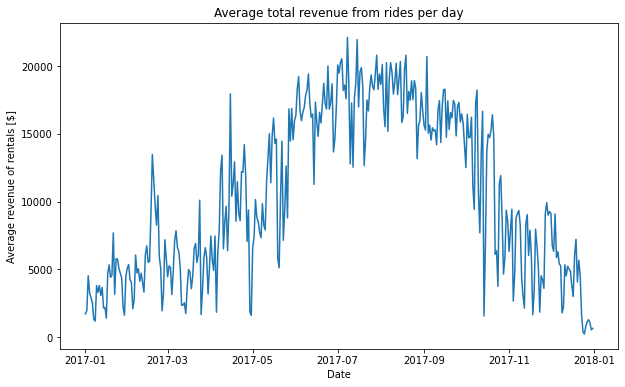

In [99]:
revenue_week = chi_data.groupby("Date")["Revenue"].count()
revenue_week = pd.DataFrame(revenue_week)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(revenue_week)

ax.set_title('Average total revenue from rides per day')
ax.set_ylabel('Average revenue of rentals [$]')
ax.set_xlabel('Date')
plt.show()

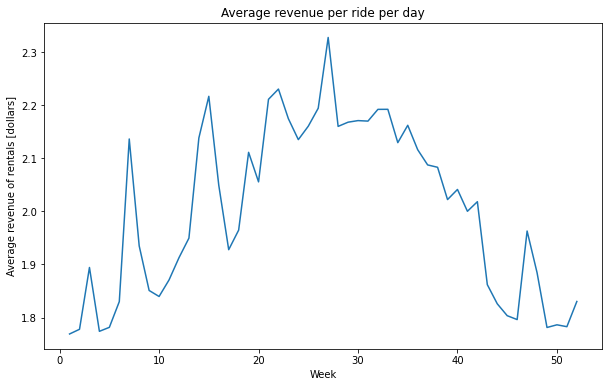

In [100]:
revenue_week = chi_data.groupby("Week")["Revenue"].mean()
revenue_week = pd.DataFrame(revenue_week)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(revenue_week)

ax.set_title('Average revenue per ride per day')
ax.set_ylabel('Average revenue of rentals [dollars]')
ax.set_xlabel('Week')
plt.show()

# `Predictive analytics`

## Feature engineering

### Data preparation

In [101]:
# initialize dataframe fot the regression models
reg_mod = rentals_date_hour['Bike Usage']
reg_mod = pd.DataFrame(reg_mod)
reg_mod['date_hour'] = reg_mod.index

reg_mod['Temp'] = chi_weather_2017.groupby("date_time")['mean_temp'].mean()
reg_mod['Precip'] = chi_weather_2017.groupby("date_time")['precip'].max()

# fill Nan-Values which occur due to error
reg_mod = reg_mod.fillna(method = "bfill")

In [102]:
# categorizing the hours into dummy variables
reg_mod["Hour"] =  reg_mod["date_hour"].swifter.apply(lambda x: x.hour)
reg_mod["IsNight"] = reg_mod["Hour"].swifter.apply(lambda x: 1 if ((x <= 5) | (x == 23)) else 0)
reg_mod["Is1RushHour"] = reg_mod["Hour"].swifter.apply(lambda x: 1 if ((x == 7) | (x == 8)) else 0)
reg_mod["IsMorningNoon"] = reg_mod["Hour"].swifter.apply(lambda x: 1 if ((x == 6) | ((x >= 9) & (x <=15)) ) else 0)
reg_mod["Is2RushHour"] = reg_mod["Hour"].swifter.apply(lambda x: 1 if ((x >= 16) & (x <= 18)) else 0)
#reg_mod["IsEvening"] = reg_mod["Hour"].swifter.apply(lambda x: 1 if ((x >= 19) & (x <= 22)) else 0)

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

In [103]:
# categorizing the week into dummy variables
reg_mod["Weekday"] = reg_mod["date_hour"].swifter.apply(lambda x: x.weekday())
reg_mod["IsWeekday"] = reg_mod["Weekday"].swifter.apply(lambda x: 1 if (x <= 4) else 0)

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

In [104]:
# categorizing the months into dummy variables
reg_mod["Month"] = reg_mod["date_hour"].swifter.apply(lambda x: x.month)
reg_mod["IsWinter"] = reg_mod["Month"].swifter.apply(lambda x: 1 if ((x <= 3) | (x >= 11)) else 0)
#reg_mod["IsSprAut"] = reg_mod["Month"].swifter.apply(lambda x: 1 if ((x == 4) | (x == 5) | (x == 10)) else 0)
reg_mod["IsSummer"] = reg_mod["Month"].swifter.apply(lambda x: 1 if ((x >= 6) & (x <= 9) ) else 0)

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

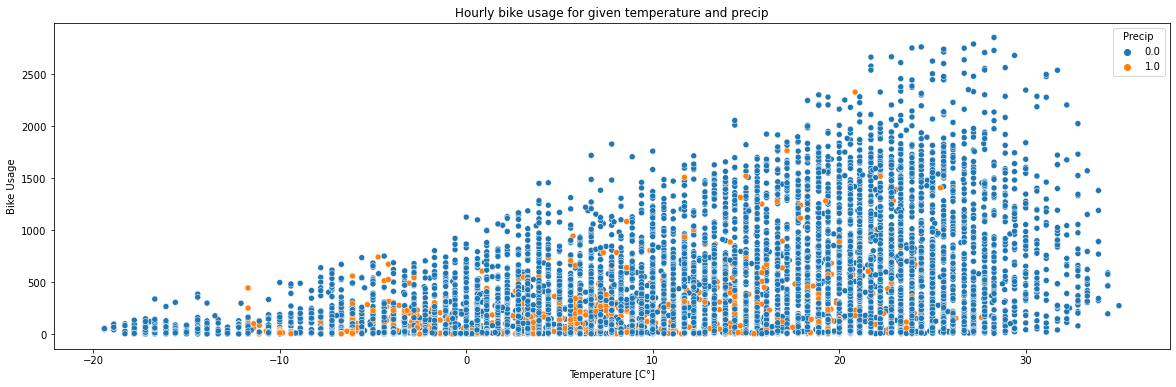

In [105]:
plt.figure(figsize = (20,6))

sns.scatterplot(x=reg_mod["Temp"], y=reg_mod["Bike Usage"], 
                hue=reg_mod["Precip"])

plt.title("Hourly bike usage for given temperature and precip")

plt.xlabel("Temperature [C°]")
plt.show()

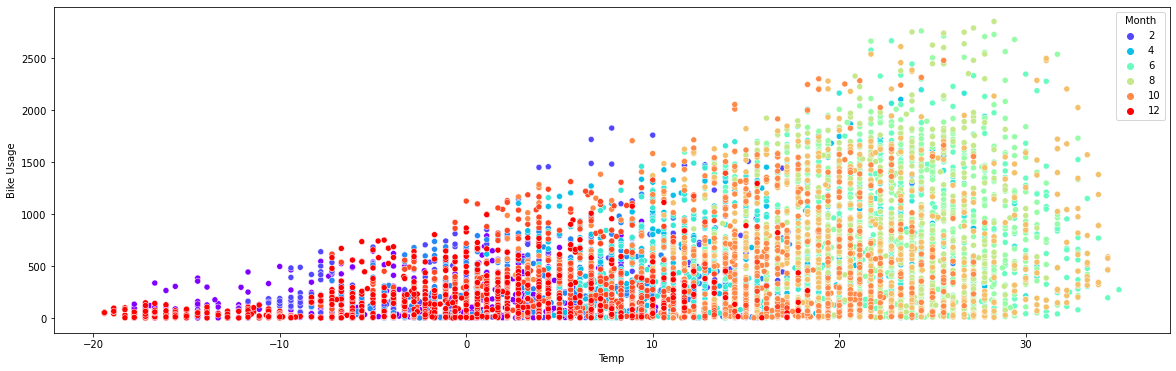

In [106]:
plt.figure(figsize = (20,6))

sns.scatterplot(x=reg_mod["Temp"], y=reg_mod["Bike Usage"], 
                hue=reg_mod["Month"], palette= "rainbow")
plt.show()

In [107]:
# dropping unnecessary columns
reg_mod.pop("Month")
reg_mod.pop("Weekday")
reg_mod.pop("Hour")
reg_mod.pop("date_hour")

date_hour
2017-01-01 00:00:00   2017-01-01 00:00:00
2017-01-01 01:00:00   2017-01-01 01:00:00
2017-01-01 02:00:00   2017-01-01 02:00:00
2017-01-01 03:00:00   2017-01-01 03:00:00
2017-01-01 04:00:00   2017-01-01 04:00:00
                              ...        
2017-12-31 19:00:00   2017-12-31 19:00:00
2017-12-31 20:00:00   2017-12-31 20:00:00
2017-12-31 21:00:00   2017-12-31 21:00:00
2017-12-31 22:00:00   2017-12-31 22:00:00
2017-12-31 23:00:00   2017-12-31 23:00:00
Name: date_hour, Length: 8743, dtype: datetime64[ns]

### Define dependent and independent variables

In [108]:
# dependent variables
y = reg_mod['Bike Usage'].values

# independent varibles
reg_mod_columns = list(reg_mod)
reg_mod_columns.remove('Bike Usage')

# feature vector
X = np.array(reg_mod[reg_mod_columns])

### Divide data into traing, holdout and test set

In [109]:
# 70-30 split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42 )

# split X_train to achive 50-20-30 split
X_train, X_hold, y_train, y_hold = train_test_split(X_train, y_train, test_size=(0.2/0.7),random_state=42 )

In [110]:
print(len(X_train),len(X_hold),len(X_test))

4371 1749 2623


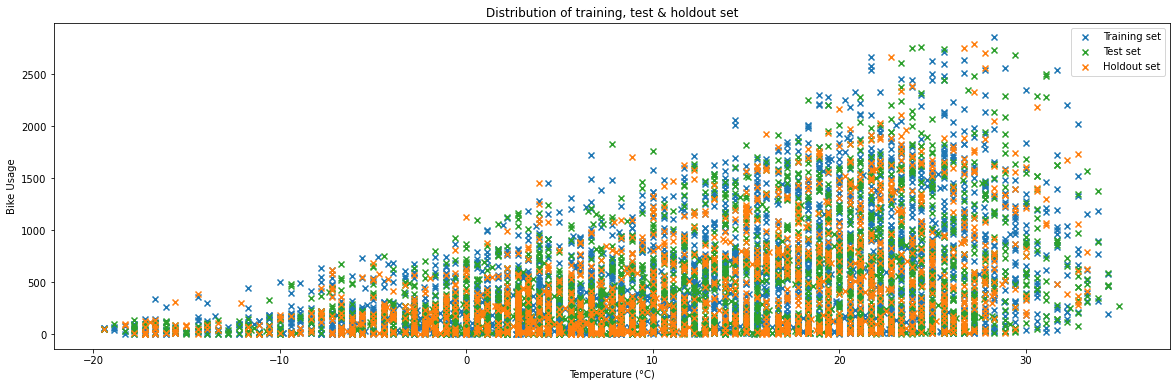

In [111]:
train = X_train[:,0:1]
test = X_test[:,0:1]
holdout = X_hold[:,0:1]

plt.figure(figsize = (20,6))
plt.scatter(train, y_train, marker='x', color="C0")
plt.scatter(test, y_test, marker='x', color="C2")
plt.scatter(holdout, y_hold, marker='x', color="C1")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Usage")
plt.title("Distribution of training, test & holdout set")
plt.legend(['Training set', 'Test set', 'Holdout set'])
plt.show()

## Model building

### Linear regression

In [116]:
# function to predict values for given data set (X_eva) with linear model wich was trained on X_train and y_train 
def lin_reg_prediction(X_train, X_eva, y_train):
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    
    # print("Coefficients:", lin_model.coef_)
    # print("Intercept: ", lin_model.intercept_)
    
    return lin_model.predict(X_eva)

In [117]:
prediction_train = lin_reg_prediction(X_train, X_train, y_train)    
prediction_hold = lin_reg_prediction(X_train, X_hold, y_train)

print("MSE train: ", mean_squared_error(y_train, prediction_train))
print("MSE hold: ", mean_squared_error(y_hold, prediction_hold))
    
print("MAE train: ", mean_absolute_error(y_train, prediction_train))
print("MAE hold: " , mean_absolute_error(y_hold, prediction_hold))

print("R2 train: ", r2_score(y_train, prediction_train))
print("R2 hold: ", r2_score(y_hold, prediction_hold))

MSE train:  96712.8324071956
MSE hold:  91676.21773890329
MAE train:  227.16490392363784
MAE hold:  225.86187052864045
R2 train:  0.6123712081522823
R2 hold:  0.6301075249614226


### Polynomial regression

In [118]:
# function to predict values for given data set (X_eva) with polynomials of a certain degree (d) in linear model wich was trained on X_train and y_train  

def poly_reg_prediction(X_train, X_eva, y_train, d):
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    X_train_poly = poly_reg.fit_transform(X_train)
    X_hold_poly = poly_reg.fit_transform(X_eva)
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(X_train_poly, y_train)
    
    # print("Coefficients:", lin_reg_Poly.coef_)
    # print("Intercept: ", lin_reg_Poly.intercept_)

    return lin_reg_Poly.predict(X_hold_poly)

minimal MSE  47099.40352099596
degree for minimal MSE  3
minimal MAE  134.61097175454887
degree for minimal MAE  3


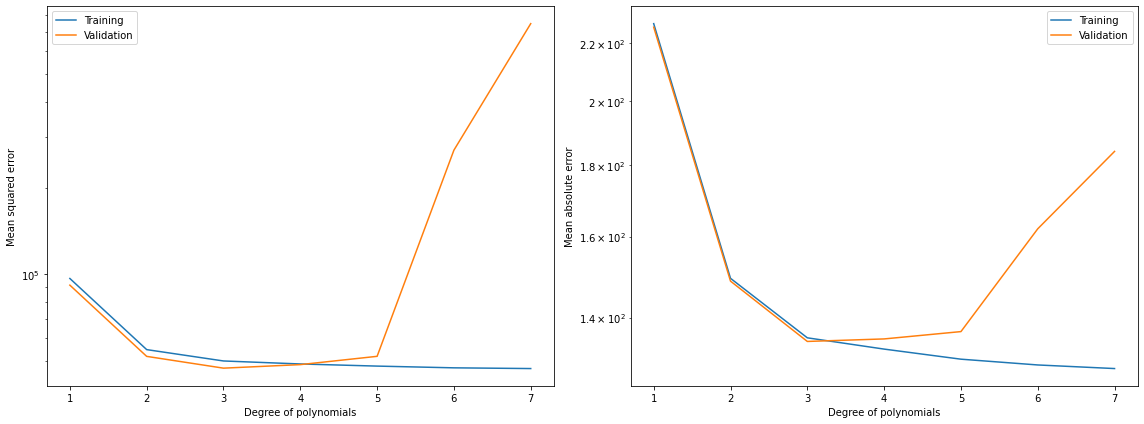

In [119]:
MSE_train = []
MSE_hold = []
MAE_train = []
MAE_hold = []
R2_train_values = []
R2_hold_values = []

min_MSE = sys.maxsize
min_MSE_deg = sys.maxsize
min_MAE = sys.maxsize
min_MAE_deg = sys.maxsize
    
for deg in range(1,8): 
    y_train_pred = poly_reg_prediction(X_train, X_train, y_train, deg)
    y_hold_pred = poly_reg_prediction(X_train, X_hold, y_train, deg)
    
    # compute errors and append them
    MSE_train.append(mean_squared_error(y_train, y_train_pred))
    MSE_hold.append(mean_squared_error(y_hold, y_hold_pred))
    
    MAE_train.append(mean_absolute_error(y_train, y_train_pred))
    MAE_hold.append(mean_absolute_error(y_hold, y_hold_pred))
    
    # To check which hyperparameters we should select we store the minimal error metrics and the degree
    # on which they were reached.
    if (min(MSE_hold) < min_MSE):
            min_MSE = min(MSE_hold)
            min_MSE_deg = deg
         
    if (min(MAE_hold) < min_MAE):
            min_MAE = min(MAE_hold)
            min_MAE_deg = deg
            
print("minimal MSE ", min_MSE)
print("degree for minimal MSE ", min_MSE_deg)
print("minimal MAE ",min_MAE)
print("degree for minimal MAE ",min_MAE_deg)

    
Fig, ax = plt.subplots(1, 2, figsize = (16,6)) 
ax[0].semilogy(range(1, deg + 1), MSE_train, range(1, deg + 1), MSE_hold)
ax[1].semilogy(range(1, deg + 1), MAE_train, range(1, deg + 1), MAE_hold)
ax[0].legend(["Training", "Validation"])
ax[1].legend(["Training", "Validation"])
ax[0].set_xlabel("Degree of polynomials")
ax[1].set_xlabel("Degree of polynomials")
ax[0].set_ylabel("Mean squared error")
ax[1].set_ylabel("Mean absolute error")
Fig.tight_layout()
plt.show()

=> We decided to use the **polynomial degree** of **3** for our model evaluation. For evaluation see below.

### Ridge regression (L2)

In [120]:
# function to predict values for given data set (X_eva) with polynomials of a certain degree (d) and regularization terms with a certain lambda/alpha (alpha) in a ridge model wich was trained on X_train and y_train

def ridge_reg_prediction(X_train, X_eva, y_train, d, alpha):
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    X_train_poly = poly_reg.fit_transform(X_train)
    X_hold_poly = poly_reg.fit_transform(X_eva)
    
    model_L2 = Ridge(alpha = alpha, normalize = True, solver = 'lsqr') # select least squares regression as solver
    model_L2.fit(X_train_poly, y_train)
    
    # print("Coefficients:", model_L2.coef_)
    # print("Intercept: ", model_L2.intercept_)
    
    return model_L2.predict(X_hold_poly)

In [121]:
# function that loops threw all lambdas/alphas for a certain degree (deg) and uses the ridge_reg_prediction for predication
def ridge_reg_degree(deg):
    err_train_MSE = []
    err_hold_MSE = []

    err_train_MAE = []
    err_hold_MAE = []

    min_MSE = sys.maxsize
    min_MSE_alpha = sys.maxsize
    min_MAE = sys.maxsize
    min_MAE_alpha = sys.maxsize
     
    for alpha in np.logspace(-10,10,100):
        prediction_train = ridge_reg_prediction(X_train, X_train, y_train, deg, alpha)
        prediction_hold = ridge_reg_prediction(X_train, X_hold, y_train, deg, alpha)

        err_train_MSE.append(mean_squared_error(y_train, prediction_train))
        err_hold_MSE.append(mean_squared_error(y_hold, prediction_hold))

        err_train_MAE.append(mean_absolute_error(y_train, prediction_train))
        err_hold_MAE.append(mean_absolute_error(y_hold, prediction_hold))
        
         # To check which alpha/lambda we should select we store the minimal error metrics and the alpha/lambda
            # on which they were reached.
        if (min(err_hold_MSE) < min_MSE):
            min_MSE = min(err_hold_MSE)
            min_MSE_alpha = alpha
         
        if (min(err_hold_MAE) < min_MAE):
            min_MAE = min(err_hold_MAE)
            min_MAE_alpha = alpha
        
    Fig, ax = plt.subplots(1, 2, figsize = (16,6)) 
    ax[0].loglog(np.logspace(-10,10,100), err_train_MSE, np.logspace(-10,10,100), err_hold_MSE)
    ax[1].loglog(np.logspace(-10,10,100), err_train_MAE, np.logspace(-10,10,100), err_hold_MAE)
    ax[0].legend(["Training", "Validation"])
    ax[1].legend(["Training", "Validation"])
    ax[0].set_xlabel("$\lambda$")
    ax[1].set_xlabel("$\lambda$")
    ax[0].set_ylabel("Mean squared error")
    ax[1].set_ylabel("Mean absolute error")
    Fig.tight_layout()
    plt.show()
    
    print("Degree: ", deg)
    print("minimal MSE: ", min_MSE)
    print("alpha for minimal MSE: ", min_MSE_alpha)
    print("minimal MAE: ",min_MAE)
    print("alpha for minimal MAE: ", min_MAE_alpha)

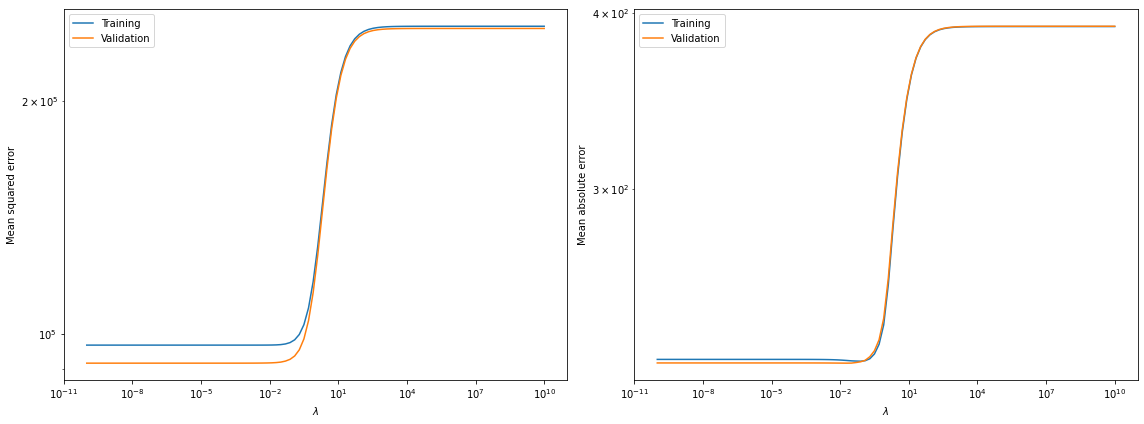

Degree:  1
minimal MSE:  91663.40891213734
alpha for minimal MSE:  1e-10
minimal MAE:  225.76063822940543
alpha for minimal MAE:  0.019179102616724848


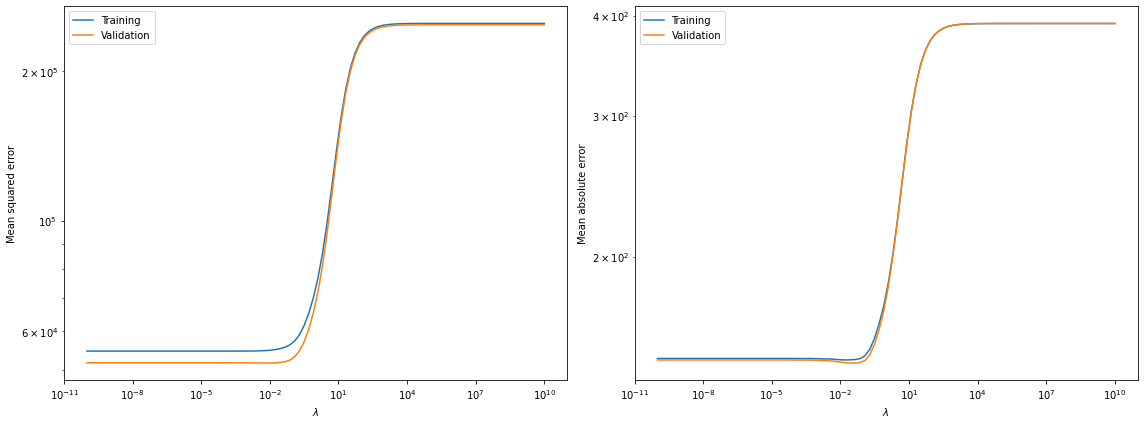

Degree:  2
minimal MSE:  51740.9412080804
alpha for minimal MSE:  0.007564633275546291
minimal MAE:  147.3277368860546
alpha for minimal MAE:  0.04862601580065353


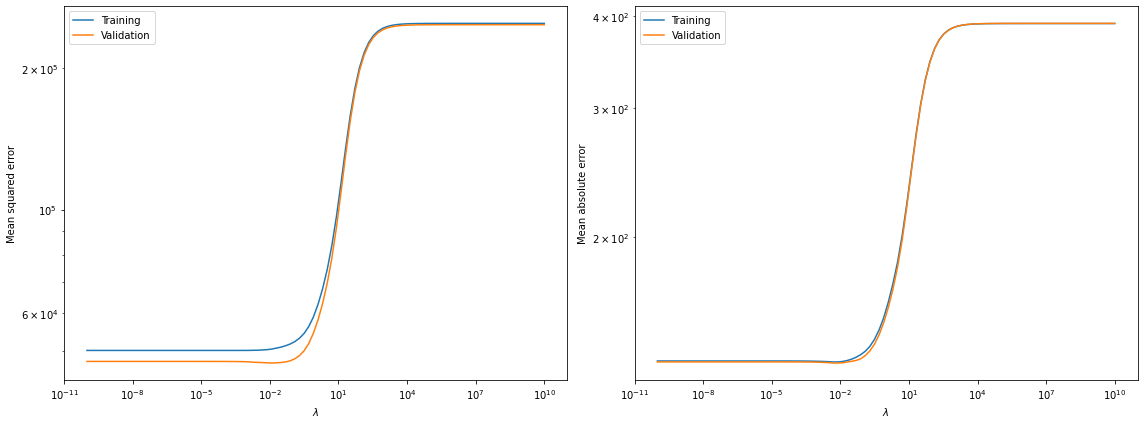

Degree:  3
minimal MSE:  47042.14905154924
alpha for minimal MSE:  0.012045035402587835
minimal MAE:  134.61563769407616
alpha for minimal MAE:  0.007564633275546291


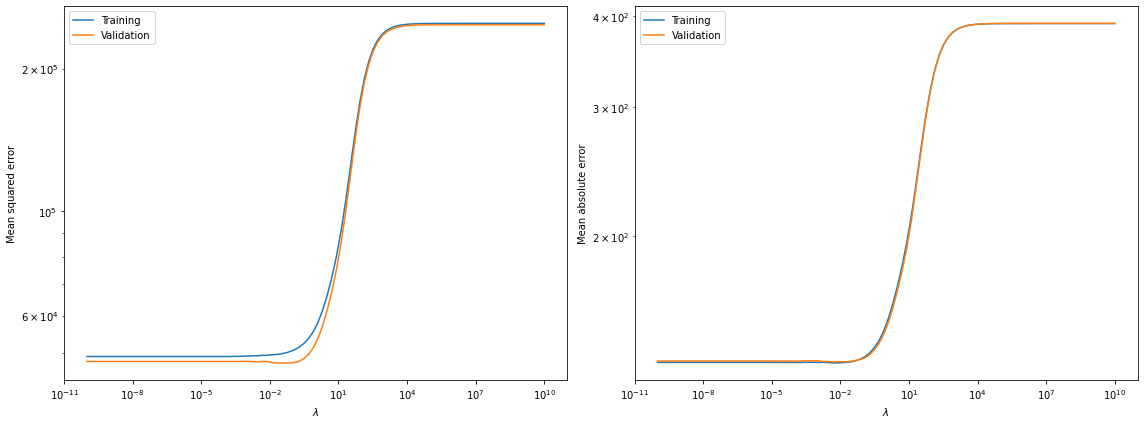

Degree:  4
minimal MSE:  47643.868805295584
alpha for minimal MSE:  0.04862601580065353
minimal MAE:  134.3326904400375
alpha for minimal MAE:  0.004750810162102793


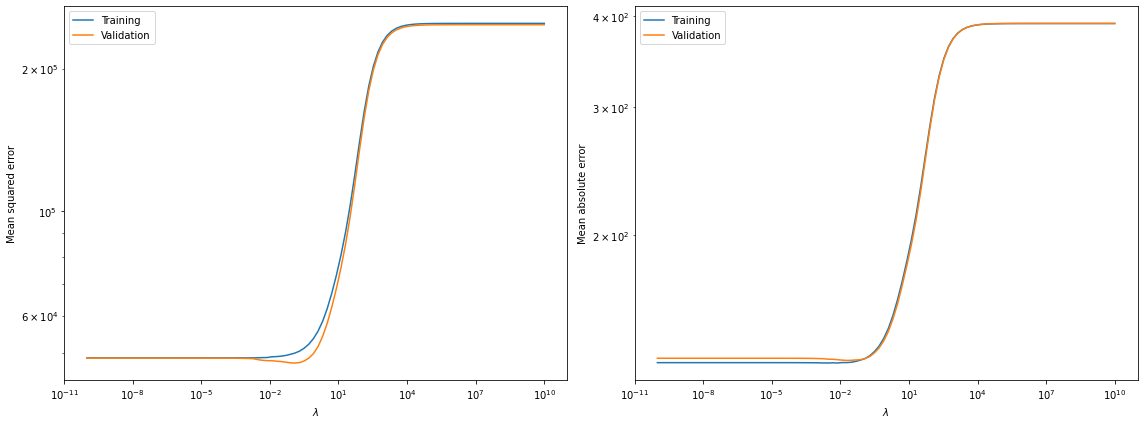

Degree:  5
minimal MSE:  47654.5415926163
alpha for minimal MSE:  0.12328467394420634
minimal MAE:  134.23863465162836
alpha for minimal MAE:  0.019179102616724848


In [124]:
# CAREFUL this takes a huge amount of resources (especially RAM)
# if this takes too long (or crashes before terminating) simply reduce the range of degrees

# loops threw a given degree range and uses the ridge_reg_degree(deg) function to get the error metrics for 
# a certain set of hyperparameters. 
for deg in range(1,8):
    ridge_reg_degree(deg)

=> We decided to use the polynomial **degree** of **3** and an **alpha** of **0.0075646332755** for our model evaluation. For evaluation see below.

### Decision tree regression

In [125]:
# function to predict values for given data set (X_eva) with a certain tree depth (tree_depth) in a tree model wich was trained on X_train and y_train
def tree_reg_prediction(X_train, X_eva, y_train, tree_depth):
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,criterion="mse")
    Tree_reg.fit(X_train, y_train)
    
    return Tree_reg.predict(X_eva)

52589.4488689414
9
139.95614723607812
9


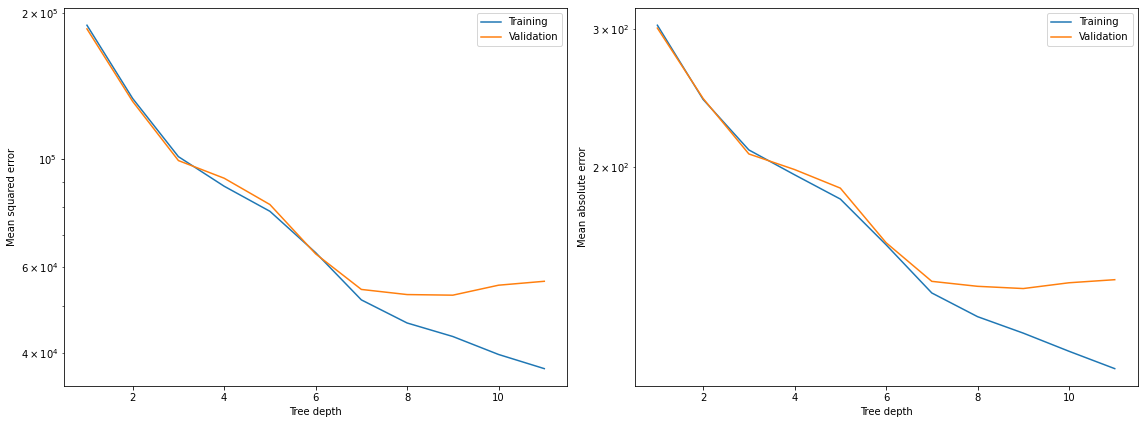

In [126]:
err_train_MSE = []
err_hold_MSE = []

err_train_MAE = []
err_hold_MAE = []

min_MSE = sys.maxsize
min_MSE_depth = sys.maxsize
min_MAE = sys.maxsize
min_MAE_depth = sys.maxsize

for tree_depth in range(1,12):
    prediction_train = tree_reg_prediction(X_train, X_train, y_train, tree_depth)
    prediction_hold = tree_reg_prediction(X_train, X_hold, y_train, tree_depth)

    err_train_MSE.append(mean_squared_error(y_train, prediction_train))
    err_hold_MSE.append(mean_squared_error(y_hold, prediction_hold))

    err_train_MAE.append(mean_absolute_error(y_train, prediction_train))
    err_hold_MAE.append(mean_absolute_error(y_hold, prediction_hold))
   
    # To check which tree depth we should select we store the minimal error metrics and the tree depth
            # on which they were reached.
    if (min(err_hold_MSE) < min_MSE):
            min_MSE = min(err_hold_MSE)
            min_MSE_depth = tree_depth
         
    if (min(err_hold_MAE) < min_MAE):
            min_MAE = min(err_hold_MAE)
            min_MAE_depth = tree_depth
    
print(min_MSE)
print(min_MSE_depth)
print(min_MAE)
print(min_MAE_depth)         

Fig, ax = plt.subplots(1, 2, figsize = (16,6)) 
ax[0].semilogy(range(1, tree_depth+1), err_train_MSE, range(1, tree_depth+1), err_hold_MSE)
ax[1].semilogy(range(1,tree_depth+1), err_train_MAE, range(1, tree_depth+1), err_hold_MAE)
ax[0].legend(["Training", "Validation"])
ax[1].legend(["Training", "Validation"])
ax[0].set_xlabel("Tree depth")
ax[1].set_xlabel("Tree depth")
ax[0].set_ylabel("Mean squared error")
ax[1].set_ylabel("Mean absolute error")
Fig.tight_layout()
plt.show()

=> We decided to use the **tree depth** of **9** for our model evaluation. For evaluation see below.

### KNN regression

In [127]:
# function to predict values for given data set (X_eva) with a certain number of neighbors (neighbors) in a knn model wich was trained on X_train and y_train
def knn_reg_prediction(X_train, X_eva, y_train, neigbors):
    KNN_reg = KNeighborsRegressor(n_neighbors = neighbors)
    KNN_model = KNN_reg.fit(X_train, y_train)
    return KNN_model.predict(X_eva)

59072.6302801601
5
148.3985134362493
4


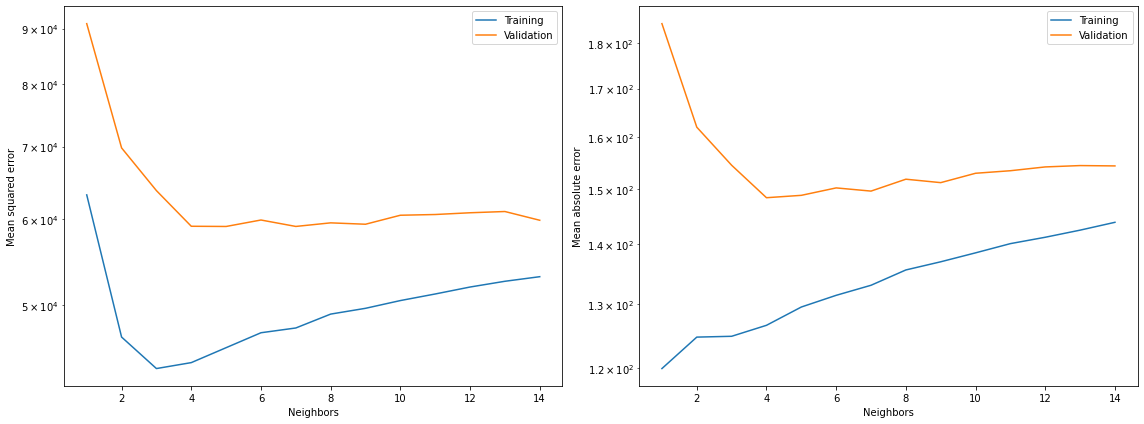

In [128]:
err_train_MSE = []
err_hold_MSE = []

err_train_MAE = []
err_hold_MAE = []

min_MSE = sys.maxsize
min_MSE_neighbors = sys.maxsize
min_MAE = sys.maxsize
min_MAE_neighbors = sys.maxsize

for neighbors in range(1,15):
    prediction_train = knn_reg_prediction(X_train, X_train, y_train, neighbors)
    prediction_hold = knn_reg_prediction(X_train, X_hold, y_train, neighbors)

    err_train_MSE.append(mean_squared_error(y_train, prediction_train))
    err_hold_MSE.append(mean_squared_error(y_hold, prediction_hold))

    err_train_MAE.append(mean_absolute_error(y_train, prediction_train))
    err_hold_MAE.append(mean_absolute_error(y_hold, prediction_hold))
    
    
    # To check which number of neighbors we should select we store the minimal error metrics and the number of neighbors
            # on which they were reached.
    if (min(err_hold_MSE) < min_MSE):
            min_MSE = min(err_hold_MSE)
            min_MSE_neighbors = neighbors
         
    if (min(err_hold_MAE) < min_MAE):
            min_MAE = min(err_hold_MAE)
            min_MAE_neighbors = neighbors     
    
print(min_MSE)
print(min_MSE_neighbors)
print(min_MAE)
print(min_MAE_neighbors)  

Fig, ax = plt.subplots(1, 2, figsize = (16,6)) 
ax[0].semilogy(range(1, neighbors+1), err_train_MSE, range(1,neighbors+1), err_hold_MSE)
ax[1].semilogy(range(1, neighbors+1), err_train_MAE, range(1, neighbors+1), err_hold_MAE)
ax[0].legend(["Training", "Validation"])
ax[1].legend(["Training", "Validation"])
ax[0].set_xlabel("Neighbors")
ax[1].set_xlabel("Neighbors")
ax[0].set_ylabel("Mean squared error")
ax[1].set_ylabel("Mean absolute error")
Fig.tight_layout()
plt.show()

=> We decided to use **4 neighbors** for our model evaluation. For evaluation see below.

## Model Evaluation

In [143]:
MSE_array = []
RMSE_array = []
MAE_array = []
R2_array = []

### Linear regression

In [144]:
linReg_predict_test = lin_reg_prediction(X_train, X_test, y_train)

MSE_array.append(mean_squared_error(y_test, linReg_predict_test))
RMSE_array.append(mean_squared_error(y_test, linReg_predict_test)**0.5)
MAE_array.append(mean_absolute_error(y_test, linReg_predict_test))
R2_array.append(r2_score(y_test, linReg_predict_test))

array_length = len(MSE_array)

print("MSE: ", MSE_array[array_length - 1])
print("RMSE: ",  RMSE_array[array_length - 1])
print("MAE: ",  MAE_array[array_length - 1])
print("R2: ",  R2_array[array_length - 1])

MSE:  95780.3880858124
RMSE:  309.48406757991984
MAE:  228.89893455582174
R2:  0.6123289032622765


### Polynomal Regression

In [145]:
polyReg_predict_test = poly_reg_prediction(X_train, X_test, y_train, 3)

MSE_array.append(mean_squared_error(y_test, polyReg_predict_test))
RMSE_array.append(mean_squared_error(y_test, polyReg_predict_test)**0.5)
MAE_array.append(mean_absolute_error(y_test, polyReg_predict_test))
R2_array.append(r2_score(y_test, polyReg_predict_test))

array_length = len(MSE_array)

print("MSE: ", MSE_array[array_length - 1])
print("RMSE: ",  RMSE_array[array_length - 1])
print("MAE: ",  MAE_array[array_length - 1])
print("R2: ",  R2_array[array_length - 1])

MSE:  51903.346784034555
RMSE:  227.8230602551782
MAE:  139.96082172880824
R2:  0.7899212169186691


### Ridge Regression

In [146]:
ridgeReg_predict_test = ridge_reg_prediction(X_train, X_test, y_train, 3, 0.007564633275546291)

MSE_array.append(mean_squared_error(y_test, ridgeReg_predict_test))
RMSE_array.append(mean_squared_error(y_test, ridgeReg_predict_test)**0.5)
MAE_array.append(mean_absolute_error(y_test, ridgeReg_predict_test))
R2_array.append(r2_score(y_test, ridgeReg_predict_test))

array_length = len(MSE_array)

print("MSE: ", MSE_array[array_length - 1])
print("RMSE: ",  RMSE_array[array_length - 1])
print("MAE: ",  MAE_array[array_length - 1])
print("R2: ",  R2_array[array_length - 1])

MSE:  52028.6509891513
RMSE:  228.0978978183519
MAE:  139.76815848653646
R2:  0.7894140481799088


### Decision tree regression

In [147]:
decTreeReg_predict_test = tree_reg_prediction(X_train, X_test, y_train, 9)

MSE_array.append(mean_squared_error(y_test, decTreeReg_predict_test))
RMSE_array.append(mean_squared_error(y_test, decTreeReg_predict_test)**0.5)
MAE_array.append(mean_absolute_error(y_test, decTreeReg_predict_test))
R2_array.append(r2_score(y_test, decTreeReg_predict_test))

array_length = len(MSE_array)

print("MSE: ", MSE_array[array_length - 1])
print("RMSE: ",  RMSE_array[array_length - 1])
print("MAE: ",  MAE_array[array_length - 1])
print("R2: ",  R2_array[array_length - 1])

MSE:  58487.538984239305
RMSE:  241.84197109732483
MAE:  147.75111824734736
R2:  0.763271700640885


### KNN regression

In [148]:
KNNReg_predict_test = knn_reg_prediction(X_train, X_test, y_train, 4)

MSE_array.append(mean_squared_error(y_test, KNNReg_predict_test))
RMSE_array.append(mean_squared_error(y_test, KNNReg_predict_test)**0.5)
MAE_array.append(mean_absolute_error(y_test, KNNReg_predict_test))
R2_array.append(r2_score(y_test, KNNReg_predict_test))

array_length = len(MSE_array)

print("MSE: ", MSE_array[array_length - 1])
print("RMSE: ",  RMSE_array[array_length - 1])
print("MAE: ",  MAE_array[array_length - 1])
print("R2: ",  R2_array[array_length - 1])

MSE:  63037.63197810576
RMSE:  251.07296146360676
MAE:  159.16635804150098
R2:  0.7448552003902233


### Comparison of regression models

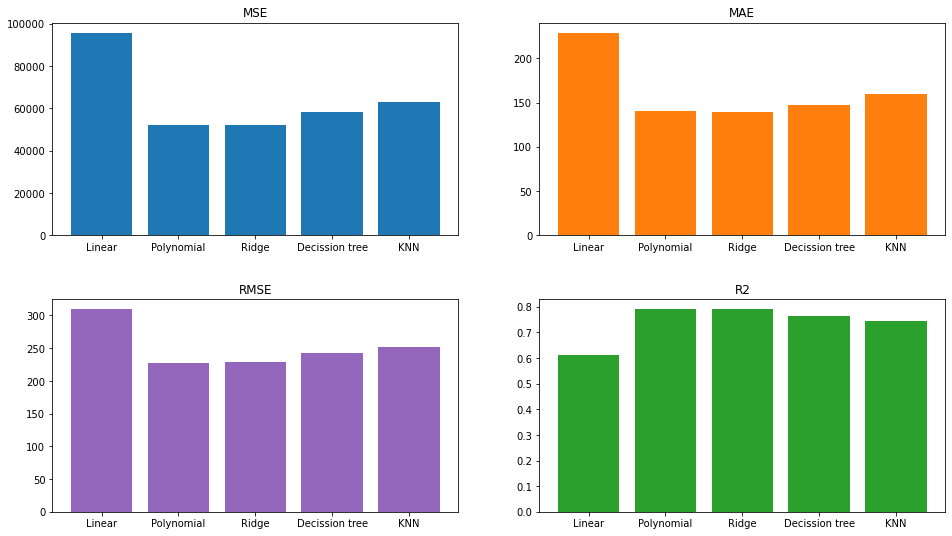

In [149]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
labels = ["Linear", "Polynomial", "Ridge", "Decission tree", "KNN"]

axes[0,0].bar(labels, MSE_array, color="#1f77b4")
axes[0,0].set_title("MSE")

axes[0,1].bar(labels, MAE_array, color="#ff7f0e")
axes[0,1].set_title("MAE");

axes[1,0].bar(labels, RMSE_array, color="#9467bd")
axes[1,0].set_title("RMSE")

axes[1,1].bar(labels, R2_array, color="#2ca02c")
axes[1,1].set_title("R2");

# set the spacing between subplots
plt.subplots_adjust(wspace=0.2, 
                    hspace=0.3)
plt.show()